In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import subprocess
import re
import os
from IPython.display import HTML
from scipy.interpolate import make_interp_spline
import jellyfish
import requests

import warnings

warnings.filterwarnings('ignore')

In [2]:
# Define FlowingData-inspired color palette
analysis_colors = ['#4e79a7', '#f28e2c', '#e15759', '#76b7b2', '#59a14f', 
                        '#edc949', '#af7aa1', '#ff9da7', '#9c755f', '#bab0ab']

In [3]:
def set_notebook_style():
    """Apply FlowingData-style formatting to the notebook"""
    
    # Define custom CSS for markdown
    css = """
    <style>
        /* Base typography */
        .jupyter-notebook,
        .jp-Notebook {
            font-family: 'Arial', 'DejaVu Sans', 'Liberation Sans', 'sans-serif;
        }

        .jp-InputPrompt,
        .jp-OutputArea-prompt {
            display: none;
        }
        
        /* Base typography */
        body {
            line-height: 1.6;
            color: #333333;
            max-width: 900px;
            margin: 0 auto;
            padding: 20px;
            background-color: white;
        }
        
        /* Headings */
        h1 {
            margin: 0;
            padding: 0;
            border: 0;
            font: inherit;
            vertical-align: baseline;
            font-style: normal;
            font-weight: 500;
            color: #000;
            font-size: 1.75rem;
            margin-bottom: .5em;
            margin-top: -2px;
            line-height: 1.3em;
        }
        
        h2 {
            font-size: 24px;
            font-weight: 600;
            color: #333333;
            margin-top: 30px;
            margin-bottom: 15px;
        }
        
        h3 {
            font-size: 20px;
            font-weight: 500;
            color: #555555;
            margin-top: 25px;
            margin-bottom: 10px;
        }
        
        /* Paragraphs and text */
        p {
            color: #111;
            padding: 0;
            border: 0;
            font: inherit;
            vertical-align: baseline;
            margin: 0 0 1.4rem 0;
            line-height: 1.6em;
        }
        
        /* Header styles that don't overlap content */
        .jp-Notebook {
            /* padding-top: 70px !important;  Add padding to notebook container */
        }
        
        .fixed-header {
            position: fixed;
            top: 0;
            left: 0;
            width: 100%;
            height: 60px;
            background-color: #fff;
            border-bottom: 1px solid #e0e0e0;
            z-index: 1000;
            display: flex;
            align-items: center;
            box-shadow: 0 2px 5px rgba(0,0,0,0.1);
            padding: 0 20px;
        }
        
        .fixed-header .logo {
            height: 40px;
            margin-right: 20px;
        }
        
        .fixed-header .nav-links a {
            margin-right: 15px;
            text-decoration: none;
            color: #333;
            font-weight: bold;
        }
        
        .fixed-header .nav-links a:hover {
            color: #007acc;
        }
        
        /* Additional selector to push down the first element */
        .cell:first-of-type {
            margin-top: 60px;
        }
        
        /* Key statistics */
        .key-stat {
            font-size: 36px;
            font-weight: 700;
            color: #333333;
            margin: 20px 0;
        }
        
        .stat-label {
            font-size: 16px;
            font-weight: 400;
            color: #666666;
            margin-bottom: 30px;
        }
        
        /* Notes and captions */
        .note {
            font-size: 14px;
            color: #666666;
            font-style: italic;
            margin-top: 10px;
        }
        
        /* Tables */
        table {
            border-collapse: collapse;
            width: 100%;
            margin: 25px 0;
            font-size: 15px;
        }
        
        th {
            text-align: left;
            padding: 12px 10px;
            border-bottom: 1px solid #e0e0e0;
            font-weight: 600;
        }
        
        td {
            padding: 10px;
            border-bottom: 1px solid #f0f0f0;
        }
        
        /* Data highlights */
        .highlight {
            background-color: #fef8e0;
            padding: 2px 0;
        }
        
        /* Image captions */
        .caption {
            font-size: 14px;
            color: #666666;
            text-align: center;
            margin-top: 5px;
            margin-bottom: 30px;
        }
    </style>
    """
    css = f"""<style>{css}</style>"""
    
    return HTML(css)

In [4]:
def style_chart(ax, title, xlabel=None, ylabel=None, formatter=None, data_labels=False, legend=True, legend_loc='best'):
    """
    Applies a consistent style to the chart elements.

    Args:
        ax (matplotlib.axes._axes.Axes): The axes object to style.
        title (str): The title of the chart.
        xlabel (str): The label for the x-axis.
        ylabel (str): The label for the y-axis.
        formatter (callable, optional): A formatting function for the x-axis. Defaults to None.
        data_labels (bool, optional): Whether to add data labels to the bars. Defaults to False.
        legend (bool, optional): Whether to display the legend. Defaults to True.
        legend_loc (str, optional): The location of the legend. Defaults to 'best'.
    """
    ax.set_title(title, fontsize=16, fontweight='bold', pad=15)
    
    if xlabel:
        ax.set_xlabel(xlabel, fontsize=12, fontweight='regular', labelpad=10)
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=12, fontweight='regular', labelpad=10)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Style the grid
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    
    if legend:
        ax.legend(frameon=False, loc=legend_loc)

    if formatter:
        ax.xaxis.set_major_formatter(formatter)

    if data_labels:
        # for i, v in enumerate(ax.patches):
        #     width = v.get_width()
        #     ax.text(
        #         width + 2,  # Reduced spacing
        #         v.get_y() + v.get_height()/2,
        #         f'${width:,.1f}K' if 'Thousands' in xlabel 
        #         else f'${width:.1f}M' if 'Millions' in xlabel 
        #         else f'{width:.2f}%' if 'Percentage' in xlabel 
        #         else f'{int(width):,}', 
        #         va='center', fontsize=8)
        ax.xaxis.set_visible(False)
    
    plt.tight_layout()

def create_contractor_summary_plot(ax, data, plot_type, title, xlabel, ylabel, colors, max_value, unit=1, unit_name='', formatter=None, decimals=0):
    """
    Creates a bar plot summarizing contractor data.

    Args:
        ax (matplotlib.axes._axes.Axes): The axes object to plot on.
        data (pandas.core.series.Series): The data to plot.
        max_value (float): The value above which bars are highlighted.
        plot_type (str): The type of plot ('sum', 'mean', 'count', 'percentage').
        title (str): The title of the chart.
        xlabel (str): The label for the x-axis.
        ylabel (str): The label for the y-axis.
        colors (list): List of colors to use for the bars.
        unit (int or float): Unit to divide the data by for better readability.
        unit_name (str): Unit name to display in data labels.
        formatter (callable, optional): A formatting function for the x-axis. Defaults to None.
        decimals (int, optional): Number of decimal places to display in data labels. Defaults to 0.
    """

    
    # Determine colors for bars
    colors_plot = [colors[0] if data[i] >= max_value else '#e15759' if data[i] < 0 else colors[4] for i in data.index]
    
    # Create bar plot
    sns.barplot(x=data.values/unit, y=data.index, ax=ax, palette=colors_plot)
    
    # Set the bar opacity and data labels based on the 75th percentile
    for i, bar in enumerate(ax.patches):
        bar.set_alpha(0.8)
        v = data.values[i]
        if v < max_value and v > 0:
            bar.set_alpha(0.1)
        else:
            width = bar.get_width()
            x_pos = bar.get_x()
            
            # Adjust text position based on value
            smidge = width + (width * 0.01)
            x_text = x_pos + width + (width * 0.01)
            if width >= 0:
                ha = 'left'
            else:
                ha = 'right'
            
            ax.text(x_text, bar.get_y() + bar.get_height()/2,
                    f'${v/unit:,.{decimals}f}{unit_name}' if plot_type in ['sum', 'mean'] else f'{v:,.{decimals}f}' if plot_type == 'count' else f'{v * 100:.{decimals}f}%',
                    va='center', ha=ha, fontweight='bold')
        
        # Add a subtle border to each bar
        bar.set_edgecolor(mpl.colors.to_rgba(bar.get_facecolor(), alpha=1))
        bar.set_linewidth(2)

    
    # Apply consistent styling using the style_chart() function
    style_chart(ax, title, xlabel, ylabel, data_labels=True, formatter=formatter)

In [5]:
# Set the default style for the plots
# Configure matplotlib/seaborn for FlowingData-style plots
plt.style.use('fivethirtyeight')

# Set custom matplotlib parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans', 'sans-serif']
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 120
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'regular'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['axes.edgecolor'] = '#e0e0e0'
plt.rcParams['axes.linewidth'] = 0.8
plt.rcParams['grid.color'] = '#e0e0e0'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.subplot.wspace'] = 0.3
plt.rcParams['figure.subplot.hspace'] = 0.3
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.prop_cycle'] = mpl.cycler(color=analysis_colors)

# Set seaborn style for consistency with matplotlib
sns.set_style("whitegrid", {
    'axes.edgecolor': '#e0e0e0',
    'grid.color': '#e0e0e0',
    'axes.grid': True,
    'axes.axisbelow': True
})
sns.set_palette(analysis_colors)

# Enable for data analysis sections
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [6]:
# Apply styling
display(set_notebook_style())

In [7]:
# Define top contractors to analyze
top_contractors = [
    {"name": "Deloitte"},
    {"name": "Accenture"},
    {"name": "Booz Allen Hamilton"},
    {"name": "General Dynamics"},
    {"name": "Leidos"},
    {"name": "Guidehouse"},
    {"name": "HII MISSION TECHNOLOGIES CORP"},
    {"name": "Science Applications International Corporation"},
    {"name": "CGI"},
    {"name": "International Business Machines Corporation"}
]

In [8]:
def find_recipient(keyword):
    url = "https://api.usaspending.gov/api/v2/recipient/"
    headers = {
        "Accept": "application/json",
        "Content-Type": "application/json",
        "X-Requested-With": "USASpendingFrontend"
    }
    payload = {
        "order": "desc",
        "sort": "amount",
        "page": 1,
        "limit": 50,
        "award_type": "all",
        "keyword": keyword
    }
    response = requests.post(url, headers=headers, json=payload)
    return response.json()

def parse_response(keyword, response):
    """
    Extracts the UEIs from the API response and returns a dictionary 
    mapping the keyword to its list of UEIs.
    """
    ueis = [item['uei'] for item in response.get('results', [])]
    return {keyword: {"ueis": ueis}}

def build_recipients_dict(top_contractors):
    """
    Loops through each contractor in top_contractors, fetches its API response,
    parses it, and builds a dictionary mapping contractor names to their UEIs.
    """
    recipients_dict = {}
    for contractor in top_contractors:
        name = contractor['name']
        response = find_recipient(name)
        parsed = parse_response(name, response)
        recipients_dict.update(parsed)
    return recipients_dict

In [9]:
all_recipients = build_recipients_dict(top_contractors)

# remove any instance of None from the ueis of the all_recipients dictionary
for key, value in all_recipients.items():
    all_recipients[key]['ueis'] = [uei for uei in value['ueis'] if uei is not None]

In [10]:
# This cell defines functions for fuzzy matching of contractor names, including Levenshtein distance and sequence alignment,
# and functions to identify and extract contractor names from text. It also includes functions to align sequences and calculate Levenshtein distance.

def metaphone_similarity(seq1_str, seq2_str):
    """
    Calculate the similarity between two strings based on the Metaphone phonetic encoding.

    Args:
        seq1_str (str): The first sequence as a string.
        seq2_str (str): The second sequence as a string.

    Returns:
        float: The Metaphone similarity score between 0 and 1.
    """
    # Get the metaphone codes for both strings
    metaphone1 = jellyfish.metaphone(seq1_str)
    metaphone2 = jellyfish.metaphone(seq2_str)
    
    # If either metaphone is empty, return 0 (no similarity)
    if not metaphone1 or not metaphone2:
        return 0.0
    
    # Calculate the Levenshtein distance between the metaphone codes
    distance = jellyfish.levenshtein_distance(metaphone1, metaphone2)
    
    # Calculate the maximum possible length between the two metaphone codes
    max_len = max(len(metaphone1), len(metaphone2))
    
    # If max_len is 0, return 1.0 (perfect match)
    if max_len == 0:
        return 1.0
    
    # Calculate the similarity score
    similarity = 1 - (distance / max_len)
    
    return similarity

def jaro_winkler_similarity(seq1_str, seq2_str):
    """
    This function is a placeholder and returns a similarity score based on the Jaro-Winkler distance.
    The mode, match_score, mismatch_score, and gap_score parameters are not used.

    Args:
        seq1_str (str): The first sequence as a string.
        seq2_str (str): The second sequence as a string.

    Returns:
        float: The Jaro-Winkler similarity score.
    """
    # preprocess strings by removing strings that contain non-alphanumeric characters
    seq1_str = ''.join(char for char in seq1_str if char.isalnum())
    seq2_str = ''.join(char for char in seq2_str if char.isalnum())
    
    return jellyfish.jaro_winkler_similarity(seq1_str, seq2_str)

def levenshtein_similarity(s1, s2):
    """
    Calculates the Levenshtein distance between two sequences using the jellyfish library and converts it to a similarity score.

    Args:
        s1 (str): The first sequence.
        s2 (str): The second sequence.

    Returns:
        float: The Levenshtein similarity score between 0 and 1.
    """
    distance = jellyfish.levenshtein_distance(s1, s2)
    max_len = max(len(s1), len(s2))
    if max_len == 0:
        return 1.0  # Both strings are empty, consider it a perfect match
    similarity = 1 - (distance / max_len)
    return similarity


In [11]:
# Filter data to include only top contractors
def contains_contractor(text, all_recipients):
    """
    Checks if a given text contains any of the top contractor names, 
    using exact matching and fuzzy matching based on Levenshtein, Jaro-Winkler, and Metaphone similarities.

    Args:
        text (str): The text to check.
        all_recipients (list): A list of contractor names.

    Returns:
        bool: True if the text contains a top contractor name or a similar name above the threshold, False otherwise.
    """
    similarity_threshold = 0.9 # Adjust as needed

    if pd.isna(text):
        return False
    str1 = text.lower()
    for contractor in all_recipients:
        exact_match = False
        # levenshtein_match = False
        jaro_winkler_match = False
        # metaphone_match = False

        str2 = contractor.lower()
        # Check for exact match
        if str1 in str2 or str2 in str1:
            exact_match = True
        # Calculate Levenshtein Distance
        # if levenshtein_similarity(str1, str2) >= similarity_threshold:
        #     levenshtein_match = True
        if jaro_winkler_similarity(str1, str2) >= similarity_threshold:
            jaro_winkler_match = True
        # if metaphone_similarity(str1, str2) >= similarity_threshold:
        #     metaphone_match = True
    return exact_match or jaro_winkler_match

# Create a function that adds a column with the closest top contractor name if a given column has a similar name to a top contractor name
def get_contractor(text, all_recipients):
    """
    Identifies and returns the closest matching contractor name from a list of top contractors,
    using the contains_contractor function for matching.

    Args:
        text (str): The text to check for contractor names.
        all_recipients (list): A list of top contractor names (as dictionaries with a 'name' key).

    Returns:
        str or None: The name of the closest matching contractor, or None if no match is found.
    """
    if pd.isna(text):
        return None

    # Use the contains_contractor function to find a match
    for contractor in all_recipients:
        if contains_contractor(text, [contractor]):  # Pass a list containing only the current contractor
            return contractor  # Return the contractor name if a match is found

    return None  # Return None if no contractor name is found

In [12]:
# process data
def process_data(df):
    # define boolean fields
    boolean_fields = [
        'alaskan_native_corporation_owned_firm', 'american_indian_owned_business', 'indian_tribe_federally_recognized',
        'native_hawaiian_organization_owned_firm', 'tribally_owned_firm', 'veteran_owned_business',
        'service_disabled_veteran_owned_business', 'woman_owned_business', 'women_owned_small_business',
        'economically_disadvantaged_women_owned_small_business', 'joint_venture_women_owned_small_business',
        'joint_venture_economic_disadvantaged_women_owned_small_bus', 'minority_owned_business',
        'subcontinent_asian_asian_indian_american_owned_business', 'asian_pacific_american_owned_business',
        'black_american_owned_business', 'hispanic_american_owned_business', 'native_american_owned_business',
        'other_minority_owned_business', 'emerging_small_business', 'community_developed_corporation_owned_firm',
        'labor_surplus_area_firm', 'us_federal_government', 'federally_funded_research_and_development_corp',
        'federal_agency', 'us_state_government', 'us_local_government', 'city_local_government', 'county_local_government',
        'inter_municipal_local_government', 'local_government_owned', 'municipality_local_government',
        'school_district_local_government', 'township_local_government', 'us_tribal_government', 'foreign_government',
        'corporate_entity_not_tax_exempt', 'corporate_entity_tax_exempt', 'partnership_or_limited_liability_partnership',
        'sole_proprietorship', 'small_agricultural_cooperative', 'international_organization', 'us_government_entity',
        'community_development_corporation', 'domestic_shelter', 'educational_institution', 'foundation', 'hospital_flag',
        'manufacturer_of_goods', 'veterinary_hospital', 'hispanic_servicing_institution', 'receives_contracts',
        'receives_financial_assistance', 'receives_contracts_and_financial_assistance', 'airport_authority',
        'council_of_governments', 'housing_authorities_public_tribal', 'interstate_entity', 'planning_commission',
        'port_authority', 'transit_authority', 'subchapter_scorporation', 'limited_liability_corporation', 'foreign_owned',
        'for_profit_organization', 'nonprofit_organization', 'other_not_for_profit_organization', 'the_ability_one_program',
        'private_university_or_college', 'state_controlled_institution_of_higher_learning', '1862_land_grant_college',
        '1890_land_grant_college', '1994_land_grant_college', 'minority_institution', 'historically_black_college',
        'tribal_college', 'alaskan_native_servicing_institution', 'native_hawaiian_servicing_institution',
        'school_of_forestry', 'veterinary_college', 'dot_certified_disadvantage', 'self_certified_small_disadvantaged_business',
        'small_disadvantaged_business', 'c8a_program_participant', 'historically_underutilized_business_zone_hubzone_firm',
        'sba_certified_8a_joint_venture'
    ]

    # columns not to drop
    fields_to_keep = [
        'contract_transaction_unique_key', 'contract_award_unique_key', 'award_id_piid', 'modification_number', 'transaction_number', 
        'parent_award_agency_id', 'parent_award_agency_name', 'parent_award_id_piid', 'parent_award_modification_number', 
        'federal_action_obligation', 'total_dollars_obligated', 'total_outlayed_amount_for_overall_award', 'base_and_exercised_options_value', 
        'current_total_value_of_award', 'base_and_all_options_value', 'potential_total_value_of_award', 
        'action_date', 'action_date_fiscal_year', 'period_of_performance_start_date', 'period_of_performance_current_end_date', 
        'period_of_performance_potential_end_date', 
        'awarding_agency_name', 'awarding_sub_agency_name', 'awarding_office_name', 
        'funding_agency_name', 'funding_sub_agency_name', 'funding_office_name', 
        'recipient_uei', 'recipient_name', 'recipient_name_raw', 'recipient_doing_business_as_name', 'cage_code', 'recipient_parent_uei', 
        'recipient_parent_name', 'recipient_parent_name_raw',
        'award_type',
        'type_of_contract_pricing', 'transaction_description', 'prime_award_base_transaction_description', 
        'action_type', 'number_of_actions', 'product_or_service_code', 'product_or_service_code_description', 
        'naics_code', 'naics_description', 'extent_competed', 'type_of_set_aside', 
        'other_than_full_and_open_competition', 'number_of_offers_received', 
        'parent_award_single_or_multiple', 
        'consolidated_contract', 'usaspending_permalink', 'initial_report_date', 'last_modified_date'
    ]

    # return only columns that have less than x% missing values
    def filter_sparse_columns(df):
        threshold = len(df) * 0.25
        return df.dropna(thresh=threshold, axis=1, subset=df.columns.difference(['recipient_doing_business_as_name']))

    # return only columns that have more than x unique values
    def filter_unique_columns(df):
        threshold = 3
        return df.loc[:, df.nunique() > threshold]

    # ============== Remove rows ==============
    # Steps that remove rows
    # =========================================

    # remove duplicates
    df = df.drop_duplicates()

    # ============== Schema change =================
    # Steps that remove columns
    # ===============================================

    # Drop columns that are not within the fields_to_keep list
    df = df.loc[:, df.columns.isin(fields_to_keep) | df.columns.isin(boolean_fields)]

    # # drop sparse columns and columns with few unique values
    # df = filter_sparse_columns(df)
    # df = filter_unique_columns(df)

    # ============== Schema update ==================
    # Steps that update the schema
    # ===============================================

    # Convert specified columns to boolean
    df[boolean_fields] = df[boolean_fields].applymap(lambda x: x == 't')

    # Convert dates and monetary values
    df['action_date'] = pd.to_datetime(df['action_date'])
    df['period_of_performance_start_date'] = pd.to_datetime(df['period_of_performance_start_date'])
    df['period_of_performance_current_end_date'] = pd.to_datetime(df['period_of_performance_current_end_date'])

    # convert naics code to string
    df['naics_code'] = df['naics_code'].astype(str)

    # ============== Computed columns ==================
    # Steps that create computed columns
    # ==================================================

    # Add contract duration in days
    df['contract_duration_days'] = (df['period_of_performance_current_end_date'] - df['period_of_performance_start_date']).dt.days

    # Add quarter and fiscal_period columns
    df['fiscal_quarter'] = df['action_date'].apply(lambda x: 'Q1' if x.month in [10,11,12] else
                                                ('Q2' if x.month in [1,2,3] else
                                                ('Q3' if x.month in [4,5,6] else 'Q4')))
    df['fiscal_period'] = df['action_date_fiscal_year'].astype(str) + '-' + df['fiscal_quarter']

    # Add month and month_period columns
    df['fiscal_month'] = df['action_date'].dt.month
    df['fiscal_month'] = df['action_date_fiscal_year'].astype(str) + '-' + df['fiscal_month'].astype(str).str.zfill(2)

    # ============== Data change ======================
    # Steps that change the data
    # ==================================================

    # Replace all instances of 
    # Bureau of Alcohol, Tobacco, Firearms and Explosives Acquisition and Property Management Division with ATF
    # Drug Enforcement Administration with DEA
    # Federal Bureau of Investigation with FBI
    # Federal Prison System / Bureau of Prisons with BOP
    # Office of Justice Programs with OJP
    # Offices, Boards and Divisions with OBD
    bureau_replacements = {
        "Bureau of Alcohol, Tobacco, Firearms and Explosives Acquisition and Property Management Division": "ATF",
        "Drug Enforcement Administration": "DEA",
        "Federal Bureau of Investigation": "FBI",
        "Federal Prison System / Bureau of Prisons": "BOP",
        "Office of Justice Programs": "OJP",
        "Offices, Boards and Divisions": "OBD",
        "Office of the Inspector General": "OIG",
        "U.S. Marshals Service": "USMS"
    }

    for long_name, short_name in bureau_replacements.items():
        df['funding_sub_agency_name'] = df['funding_sub_agency_name'].str.replace(long_name, short_name, case=False, regex=False)
        df['awarding_sub_agency_name'] = df['awarding_sub_agency_name'].str.replace(long_name, short_name, case=False, regex=False)

    return df

In [13]:
def process_unidentified_contractors(df):

    # Initialize a boolean mask to track identified rows
    matched_mask = pd.Series([False] * len(df), index=df.index)

    # # Apply filters and set 'top_contractor' accordingly
    # name_filter = df['recipient_name'].apply(lambda x: contains_contractor(x, all_recipients))
    # name_raw_filter = df['recipient_name_raw'].apply(lambda x: contains_contractor(x, all_recipients))
    # parent_filter = df['recipient_parent_name'].apply(lambda x: contains_contractor(x, all_recipients))
    # parent_raw_filter = df['recipient_parent_name_raw'].apply(lambda x: contains_contractor(x, all_recipients))
    # doing_business_filter = df['recipient_doing_business_as_name'].apply(lambda x: contains_contractor(x, all_recipients))

    name_filter = df['recipient_name'].apply(lambda x: contains_contractor(x, [c for c in all_recipients if c == "CGI"]))
    name_raw_filter = df['recipient_name_raw'].apply(lambda x: contains_contractor(x, [c for c in all_recipients if c == "CGI"]))
    parent_filter = df['recipient_parent_name'].apply(lambda x: contains_contractor(x, [c for c in all_recipients if c == "CGI"]))
    parent_raw_filter = df['recipient_parent_name_raw'].apply(lambda x: contains_contractor(x, [c for c in all_recipients if c == "CGI"]))
    doing_business_filter = df['recipient_doing_business_as_name'].apply(lambda x: contains_contractor(x, [c for c in all_recipients if c == "CGI"]))

    if name_filter.any():
        df.loc[name_filter, 'top_contractor'] = df['recipient_name'].apply(lambda x: get_contractor(x, all_recipients))
        matched_mask = matched_mask | name_filter

    if name_raw_filter.any():
        df.loc[name_raw_filter, 'top_contractor'] = df['recipient_name_raw'].apply(lambda x: get_contractor(x, all_recipients))
        matched_mask = matched_mask | name_raw_filter

    if parent_filter.any():
        df.loc[parent_filter, 'top_contractor'] = df['recipient_parent_name'].apply(lambda x: get_contractor(x, all_recipients))
        matched_mask = matched_mask | parent_filter

    if parent_raw_filter.any():
        df.loc[parent_raw_filter, 'top_contractor'] = df['recipient_parent_name_raw'].apply(lambda x: get_contractor(x, all_recipients))
        matched_mask = matched_mask | parent_raw_filter

    if doing_business_filter.any():
        df.loc[doing_business_filter, 'top_contractor'] = df['recipient_doing_business_as_name'].apply(lambda x: get_contractor(x, all_recipients))
        matched_mask = matched_mask | doing_business_filter

    df_matched = df[matched_mask]

    # set is_top_contractor to True to indicate that the contractor has been matched
    df_matched['is_matched'] = True

    return df_matched

In [14]:
# Function to process the data to find and isolate the identified contractors
def process_contractors(df):
    
    # add a column is_top_contractor to indicate that the contractor is not yet identified
    df['is_identified'] = False
    df['is_matched'] = False
    df['top_contractor'] = None

    # first, process the data for the identified top contractors by filtering on cage codes and ueis
    
    # combine all ueis from all_recipients into a list
    top_contractor_ueis = [uei for contractor in all_recipients.values() for uei in contractor['ueis']]
    # top_contractor_cage_codes = [cage_code for contractor in all_recipients if contractor == "CGI" for cage_code in contractor['cage_codes']]

    # create filters for cage codes and ueis
    # Additionally, include a filter for recipient_uei when recipient_parent_uei is NaN
    recipient_uei_filter_no_parent = df['recipient_uei'].isin(top_contractor_ueis) & df['recipient_parent_uei'].isna()
    recipient_parent_uei_filter = df['recipient_parent_uei'].isin(top_contractor_ueis)
    # cage_code_filter = df['cage_code'].isin(top_contractor_cage_codes)

    # Initialize a boolean mask to track identified rows
    identified_mask = pd.Series(False, index=df.index)

    # Apply filters and set 'is_identified' and 'top_contractor' accordingly
    if recipient_parent_uei_filter.any():
        df.loc[recipient_parent_uei_filter, 'is_identified'] = True
        df.loc[recipient_parent_uei_filter, 'top_contractor'] = df['recipient_parent_name'].apply(lambda x: get_contractor(x, all_recipients))
        identified_mask = identified_mask | recipient_parent_uei_filter

    if recipient_uei_filter_no_parent.any():
        df.loc[recipient_uei_filter_no_parent, 'is_identified'] = True
        df.loc[recipient_uei_filter_no_parent, 'top_contractor'] = df['recipient_name'].apply(lambda x: get_contractor(x, all_recipients))
        identified_mask = identified_mask | recipient_uei_filter_no_parent

    # if cage_code_filter.any():
    #     df.loc[cage_code_filter, 'is_identified'] = True
    #     df.loc[cage_code_filter, 'top_contractor'] = df['recipient_name'].apply(lambda x: get_contractor(x, all_recipients))
    #     identified_mask = identified_mask | cage_code_filter

    df_identified = df[identified_mask]

    # # process the data for the unidentified contractors
    # df_unidentified = df[~df['is_identified']]
    # df_matched = process_unidentified_contractors(df_unidentified)

    # # combine the identified and matched contractors
    # df_top_contractors_transactions = pd.concat([df_identified.reset_index(drop=True), df_matched.reset_index(drop=True)], ignore_index=True)

    # contractor_replacements = {
    #     "Science Applications International Corporation": "SAIC",
    #     "International Business Machines Corporation": "IBM",
    #     "Accenture Federal Services": "Accenture"
    # }

    # for long_name, short_name in contractor_replacements.items():
    #     df_top_contractors_transactions['top_contractor'] = df_top_contractors_transactions['top_contractor'].str.replace(long_name, short_name, case=False, regex=False)

    return df_identified

In [15]:
# read the data from analysis\data\015_Contracts_Full.csv file into a pandas dataframe
df = pd.read_csv('data/015_Contracts_Full.csv')

In [16]:
# ================================================
# 0. Data Processing
# ================================================

# process the data
df_processed = process_data(df)

In [17]:
df_transactions = df_processed.drop_duplicates()

# process the data for the top contractors
df_top_contractors_transactions = process_contractors(df_transactions)

# filter obligations greater than 0
# df_transactions = df_processed[df_processed['federal_action_obligation'] > 0]

# filter to just DOJ funded contracts
# df_transactions = df_transactions[df_transactions['funding_agency_name'] == 'Department of Justice']

# # filter to just OJP
# df_transactions = df_transactions[df_transactions['funding_sub_agency_name'] == "Office of Justice Programs"]



In [18]:
# # Group by 'award_id_piid' and 'top_contractor', then sum 'total_dollars_obligated' and 'total_outlayed_amount_for_overall_award' by the last 'action_date'
# df_award_transactions = df_top_contractors_transactions[df_top_contractors_transactions['award_id_piid'].str.contains("15JPSS21F00000457", regex=False, na=False, case=False)].sort_values('action_date')
# df_award_summary = df_award_transactions.groupby(['award_id_piid', 'action_date', 'top_contractor']).agg({
#     'modification_number': 'last',
#     'period_of_performance_start_date': 'last',
#     'period_of_performance_current_end_date': 'last',
#     'period_of_performance_potential_end_date': 'last',
#     'potential_total_value_of_award': 'last',
#     'total_dollars_obligated': 'last',
#     'total_outlayed_amount_for_overall_award': 'last',
#     'federal_action_obligation': 'sum',
#     'action_type': 'last',
#     'transaction_description': 'last'
# }).reset_index()

In [ ]:
# # create a plot that shows the total dollars obligated and total outlayed amount for the overall award for the top contractors

# # Group by 'action_date' and 'top_contractor', then sum 'total_dollars_obligated'
# df_time_series = df_top_contractors_transactions.groupby(['action_date', 'top_contractor'])['total_dollars_obligated'].sum().reset_index()

# # Pivot the table to have 'top_contractor' as columns
# df_time_series = df_time_series.pivot(index='action_date', columns='top_contractor', values='total_dollars_obligated').fillna(0)

# # Create an area chart
# plt.figure(figsize=(12, 6))

# # Plot each contractor
# for contractor in df_time_series.columns:
# 	plt.plot(df_time_series.index, df_time_series[contractor], label=contractor)

# plt.title('Total Dollars Obligated by Fiscal Month for Top Contractors')
# plt.xlabel('Date')
# plt.ylabel('Total Dollars Obligated')
# plt.xticks(rotation=45)
# plt.legend(loc='upper left')
# plt.tight_layout()
# plt.show()


In [19]:
# ================================================
# 1. Contract Volume and Value Analysis, FY24
# ================================================

# filter to include only FY23 data
df_contractors_fy23 = df_top_contractors_transactions[df_top_contractors_transactions['action_date_fiscal_year'] == 2023]

# filter to include only FY24 data
df_contractors_fy24 = df_top_contractors_transactions[df_top_contractors_transactions['action_date_fiscal_year'] == 2024]

# Calculate the sum, average, median, min, and max of obligations for DOJ in FY23
obligation_stats_doj_fy23 = df_contractors_fy23.groupby('funding_agency_name')['federal_action_obligation'].agg(['sum', 'mean', 'median', 'min', 'max', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)]).sort_values('mean', ascending=False)
obligation_stats_doj_fy23.rename(columns={'<lambda_0>':'25th', '<lambda_1>':'75th'}, inplace=True)

# Calculate the sum, average, median, min, and max of obligations for DOJ in FY24
obligation_stats_doj_fy24 = df_contractors_fy24.groupby('funding_agency_name')['federal_action_obligation'].agg(['sum', 'mean', 'median', 'min', 'max', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)]).sort_values('mean', ascending=False)
obligation_stats_doj_fy24.rename(columns={'<lambda_0>':'25th', '<lambda_1>':'75th'}, inplace=True)

# Calculate the sum, average, median, min, and max of obligations for each contractor in FY23
obligation_stats_contractor_fy23 = df_contractors_fy23.groupby('top_contractor')['federal_action_obligation'].agg(['sum', 'mean', 'median', 'min', 'max', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)]).sort_values('mean', ascending=False)
obligation_stats_contractor_fy23.rename(columns={'<lambda_0>':'25th', '<lambda_1>':'75th'}, inplace=True)
# Calculate the percentage of total obligations for each contractor
obligation_stats_contractor_fy23['percent_of_total'] = (obligation_stats_contractor_fy23['sum'] / obligation_stats_doj_fy23['sum'].iloc[0])

# Calculate the sum, average, median, min, and max of obligations for each contractor in FY24
obligation_stats_contractor_fy24 = df_contractors_fy24.groupby('top_contractor')['federal_action_obligation'].agg(['sum', 'mean', 'median', 'min', 'max', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)]).sort_values('mean', ascending=False)
obligation_stats_contractor_fy24.rename(columns={'<lambda_0>':'25th', '<lambda_1>':'75th'}, inplace=True)
# Calculate the percentage of total obligations for each contractor
obligation_stats_contractor_fy24['percent_of_total'] = (obligation_stats_contractor_fy24['sum'] / obligation_stats_doj_fy24['sum'].iloc[0])

# Calculate award counts for DOJ in FY24
award_stats_doj_fy24 = df_contractors_fy24.groupby('funding_agency_name')['award_id_piid'].agg(['count']).sort_values('count', ascending=False)

# Calculate award counts for each contractor
award_stats_contractor_fy24 = df_contractors_fy24.groupby('top_contractor')['award_id_piid'].agg(['count']).sort_values('count', ascending=False)

# Return a list of the top three contractors by total obligations
top_three_contractors_total_obligations_fy24 = obligation_stats_contractor_fy24['sum'].sort_values(ascending=False).head(3).index.tolist()

# # ====================================================
# # Section 2: Temporal Patterns Analysis, FY24 v FY23
# # ====================================================

# Quarterly peaks and risks
# filter to include only FY23 and FY24 data
df_contractors_fy23_24 = df_top_contractors_transactions[(df_top_contractors_transactions['action_date_fiscal_year'] < 2025)]
# Group by fiscal period and sum contract values
time_series_fy23_24 = df_contractors_fy23_24.groupby(['fiscal_period', 'top_contractor'])['federal_action_obligation'].sum().unstack()

# Return a list of the top three contractors by weighted average percent change in quarterly spending
top_three_contractors_quarterly_pct_change_fy23_24 = time_series_fy23_24.pct_change(axis=0).mul(time_series_fy23_24.sum(axis=0) / time_series_fy23_24.sum().sum()).mean().sort_values(ascending=False).head(3).index.tolist()

# Year-over-Year Growth   
# Merge the two series
obligation_compare_contractor_fy23_24 = pd.DataFrame({
    'FY23': obligation_stats_contractor_fy23['sum'],
    'FY24': obligation_stats_contractor_fy24['sum']
}).fillna(0)

# Calculate growth
obligation_compare_contractor_fy23_24['Growth'] = (obligation_compare_contractor_fy23_24['FY24'] - obligation_compare_contractor_fy23_24['FY23']) / obligation_compare_contractor_fy23_24['FY23']
obligation_compare_contractor_fy23_24 = obligation_compare_contractor_fy23_24.sort_values('Growth', ascending=False)

# Calculate the sum, average, median, min, and max of obligation growth for contractors
growth_stats_agency_fy23_24 = pd.DataFrame(obligation_compare_contractor_fy23_24['Growth'].agg(['mean', 'median', 'min', 'max'])).T
# add 25th and 75th percentiles
growth_stats_agency_fy23_24['25th'] = obligation_compare_contractor_fy23_24['Growth'].quantile(0.25)
growth_stats_agency_fy23_24['75th'] = obligation_compare_contractor_fy23_24['Growth'].quantile(0.75)

# ====================================================
# Section 3: Portfolio Composition Analysis, FY23 - Present
# ====================================================

# Component Specialization

# Breakdown by DOJ component
obligation_component_contractor_all = pd.crosstab(
    df_top_contractors_transactions['top_contractor'], 
    df_top_contractors_transactions['funding_sub_agency_name'], 
    values=df_top_contractors_transactions['federal_action_obligation'], 
    aggfunc='sum',
    normalize='index'
)

# Award Type Analysis

# Breakdown by Award Type
obligation_award_type_contractor_all = pd.crosstab(
    df_top_contractors_transactions['top_contractor'], 
    df_top_contractors_transactions['award_type'], 
    values=df_top_contractors_transactions['federal_action_obligation'], 
    aggfunc='sum',
    normalize='index'
)

# ====================================================
# Section 4: Competitive Landscape Analysis, FY23 - Present
# ====================================================

# Competitive Landscape Analysis

# Calculate win rates (assuming all contracts in our dataset were won)
obligation_extent_competed_contractor_all = pd.crosstab(
    df_top_contractors_transactions['top_contractor'],
    df_top_contractors_transactions['extent_competed'],
    values=df_top_contractors_transactions['federal_action_obligation'],
    aggfunc='sum',
    normalize='index'
)

# Calculate the number of sole-source contracts for DOJ
sole_source_stats_agency_fy24 = df_contractors_fy24[df_contractors_fy24['extent_competed'] == 'NOT COMPETED'].groupby('funding_agency_name')['award_id_piid'].agg(['count']).sort_values('count', ascending=False)

# Calculate the number of sole-source contracts for each contractor
sole_source_stats_contractor_fy24 = df_contractors_fy24[df_contractors_fy24['extent_competed'] == 'NOT COMPETED'].groupby('top_contractor')['award_id_piid'].agg(['count']).sort_values('count', ascending=False)
# Calculate the percentage of total sole-source contracts for each contractor
sole_source_stats_contractor_fy24['percent_of_total'] = (sole_source_stats_contractor_fy24['count'] / sole_source_stats_agency_fy24['count'].iloc[0])


# # Calculate sole-source percentages
# if 'NOT COMPETED' in obligation_extent_competed_contractor_all.columns:
#     pct_sole_source_by_contractor = obligation_extent_competed_contractor_all['NOT COMPETED'].sort_values(ascending=False)
#     pct_sole_source_by_contractor = pct_sole_source_by_contractor[pct_sole_source_by_contractor >= 0]

#     # Determine the contractor with the highest sole source percent
#     max_pct_sole_source_by_contractor = pct_sole_source_by_contractor.idxmax()
#     # Determine the 75th percentile of the sole source percentage
#     top_quartile_pct_sole_source_by_contractor = pct_sole_source_by_contractor.quantile(0.75)

# ====================================================
# Section 5: Performance Analysis, FY23 - Present
# ====================================================

# Contract duration analysis

# Calculate the sum, average, median, min, and max contract durations for each contractor
duration_stats_contractor_all = df_top_contractors_transactions.groupby('top_contractor')['contract_duration_days'].agg(['sum', 'mean', 'median', 'min', 'max', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)]).sort_values('mean', ascending=False)
duration_stats_contractor_all.rename(columns={'<lambda_0>':'25th', '<lambda_1>':'75th'}, inplace=True)

# Modification Analysis

# Calculate the sum, mean, median, min, and max number of modfications per contract for each contractor
# Group by award_id_piid and top_contractor, count modification_number and rename the column to 'count'
modfication_stats_contractor_all = df_top_contractors_transactions.groupby(['award_id_piid', 'top_contractor'])['modification_number'].count().reset_index().rename(columns={'modification_number': 'count'}, inplace=False)

# Group by top_contractor and calculate the sum, mean, median, min, and max of the modification count
modfication_stats_contractor_all = modfication_stats_contractor_all.groupby('top_contractor')['count'].agg(['sum', 'mean', 'median', 'min', 'max']).sort_values('mean', ascending=False)

# modfication_stats_contractor_all = df_top_contractors_transactions.groupby('top_contractor')['modification_number'].agg(['count']).sort_values('count', ascending=False)

# # # Treemap of contract categories
# # # Convert to format needed for treemap
# # treemap_data = []
# # for contractor in df_top_contractors_transactions['top_contractor'].unique():
# #     contractor_df = df_top_contractors_transactions[df_top_contractors_transactions['top_contractor'] == contractor]
# #     for category in contractor_df['naics_description'].unique():
# #         value = contractor_df[contractor_df['naics_description'] == category]['federal_action_obligation'].sum()
# #         treemap_data.append({
# #             'Contractor': contractor,
# #             'Category': category.split(':')[1].strip() if ':' in category else category,
# #             'Value': value
# #         })

# # treemap_df = pd.DataFrame(treemap_data)

# # ====================================================
# # Section 6: Conclusion and Key Insights
# # ====================================================

# # # Key Insights
# # # Top contractor by obligation
# # top_contractor = obligation_stats_contractor_fy24['sum'].index[0]
# # top_contractor_value = obligation_stats_contractor_fy24['sum'].iloc[0]

# # # Most specialized contractor (highest percentage with a single DOJ component)
# # if not obligation_component_contractor_all.empty:
# #     most_specialized = obligation_component_contractor_all.max(axis=1).sort_values(ascending=False).index[0]
# #     specialization_component = obligation_component_contractor_all.loc[most_specialized].idxmax()
# #     specialization_pct = obligation_component_contractor_all.loc[most_specialized].max()

# # # Contractor with highest percentage of competitive contracts
# # if 'FULL AND OPEN COMPETITION' in obligation_extent_competed_contractor_all.columns:
# #     most_competitive = obligation_extent_competed_contractor_all['FULL AND OPEN COMPETITION'].sort_values(ascending=False).index[0]
# #     competitive_pct = obligation_extent_competed_contractor_all.loc[most_competitive, 'FULL AND OPEN COMPETITION']

# # # Contractor with longest average contracts
# # longest_contracts = duration_stats_contractor_all['mean'].idxmax()
# # longest_duration = duration_stats_contractor_all.loc[longest_contracts, 'mean']

# # # show contractors that are adept at expanding the scope of their initial agreements via modification patterns
# # if not modification_stats.empty:
# #     most_modifications = modification_stats['sum'].idxmax()
# #     most_modifications_avg = modification_stats.loc[most_modifications, 'mean']

# # # sort modification_stats by mean in descending order
# # modification_stats = modification_stats.sort_values('mean', ascending=False)




<h1>Analysis of the Department of Justice $1.1B Top Contractor Landscape</h1>

<p><em>How the top contractors contribute to agency spending</em></p>
<p>March 10, 2025</p>
<p>The Department of Justice (DOJ) faces uneven contract obligation distribution, inconsistent federal contract engagement models, and clear quarterly spending trends. The top contractors exhibit specialized relationships with DOJ components that vary in competitiveness and contract duration, while modification patterns reveal their ability to expand contract scope.</p>
<h2>Key Insights</h2>
<p>Of the top contractors who have done business with DOJ in FY24, <strong>Booz Allen Hamilton</strong> leads contracting volume within DOJ with $231.5 million in obligations, a 92.1% increase from FY23. <strong>Booz Allen Hamilton</strong> shows high specialization, focusing 83.0% of its DOJ work with <strong>FBI</strong>. <strong>Guidehouse</strong> leads with the most frequent expansion of their DOJ contracts, with an average of 4.86 modifications. <strong>Leidos</strong> holds the longest average contract durations with DOJ at 1,227 days.</p>

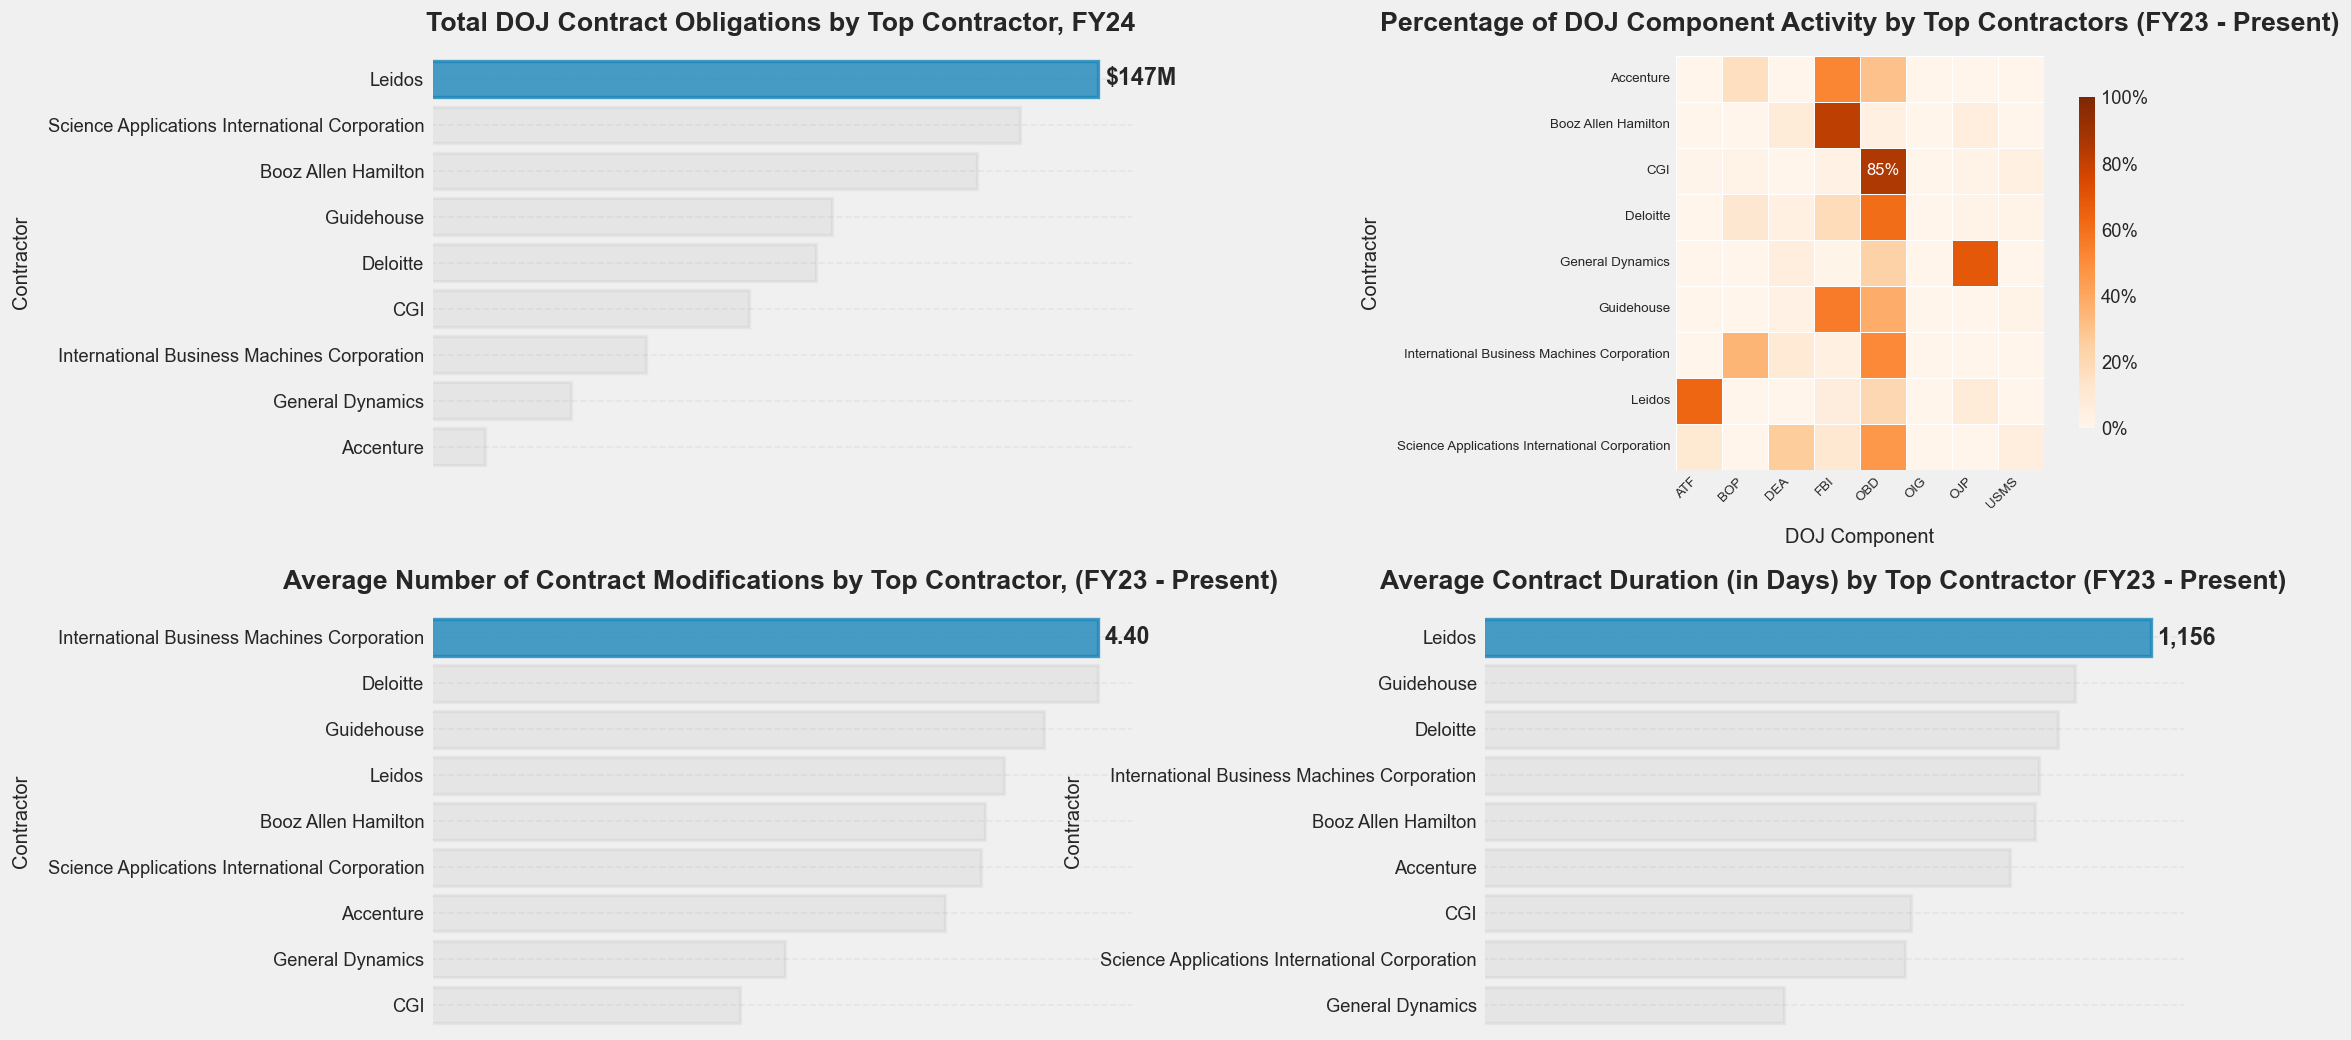

In [20]:
# Plot total contract obligations by Top Contractor along with average contract size, count of contracts, and percentage of spending
with plt.style.context('fivethirtyeight'):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    # Create a 2x2 subplot layout with an increased figure size
    fig, axs = plt.subplots(2, 2, figsize=(16.8, 10),
                            gridspec_kw={'hspace': 0.35, 'wspace': 0.5})
    
    # 1. Total contract obligations (Top-Left)
    create_contractor_summary_plot(
        ax=axs[0,0],
        data=obligation_stats_contractor_fy24['sum'].sort_values(ascending=False),
        plot_type='sum',
        title='Total DOJ Contract Obligations by Top Contractor, FY24',
        xlabel='Total Obligations ($ Millions)',
        ylabel='Contractor',
        max_value=obligation_stats_contractor_fy24['sum'].max(),
        colors=colors,
        unit=1e6,
        unit_name='M'
    )

    # 2. DOJ component activity by top contractors (Top-Right)
    ax = axs[0,1]  # Specify the target subplot
    sns.heatmap(obligation_component_contractor_all, cmap="Oranges", annot=True, fmt=".4f", linewidths=0.5, ax=ax, square=True, annot_kws={'size':10}, cbar_kws={'shrink':0.8},  cbar=True, vmin=0, vmax=1.0)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right', fontsize=8)
    for text in ax.texts: # Iterate through each text element in the heatmap
        try:
            value = float(text.get_text()) # Try to convert the text to a float value
            if value >= round(obligation_component_contractor_all.max().max(), 4):
                text.set_text(f'{value * 100:.0f}%') # If it is, add a "%" sign to the text
            else:
                text.set_text('') # Otherwise, set the text to an empty string
        except ValueError:
            print('error')
            pass  # Handle non-numeric labels

        # Set the colorbar formatter to percentage
    cbar = ax.collections[0].colorbar
    cbar.ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
  
    style_chart(ax,
                title='Percentage of DOJ Component Activity by Top Contractors (FY23 - Present)',
                ylabel='Contractor',
                xlabel='DOJ Component',
                legend=False)
    
    # 3. Average contract modifications (Bottom-Left)
    create_contractor_summary_plot(
        ax=axs[1,0],
        data=modfication_stats_contractor_all['mean'].sort_values(ascending=False),
        plot_type='count',
        title='Average Number of Contract Modifications by Top Contractor, (FY23 - Present)',
        xlabel='Average Number of Contract Modifications',
        ylabel='Contractor',
        max_value=modfication_stats_contractor_all['mean'].max(),
        colors=colors,
        unit=1,
        unit_name='',
        decimals=2
    )

    # 4. Average contract duration (Bottom-Right)
    create_contractor_summary_plot(
        ax=axs[1,1],
        data=duration_stats_contractor_all['mean'].sort_values(ascending=False),
        plot_type='count',
        title='Average Contract Duration (in Days) by Top Contractor (FY23 - Present)',
        xlabel='Average Duration',
        ylabel='Contractor',
        max_value=duration_stats_contractor_all['mean'].max(),
        colors=colors,
        unit=1,
        unit_name=''
    )
    # Adjust layout with more padding 
    plt.tight_layout()
    plt.show()


## Recommendations
- **Identify High-Concentration Risk Areas**: Target DOJ Components showing excessive reliance on single contractors like **CGI Federal** at **OBD**; implement supplier diversification strategies to reduce operational vulnerabilities.
- **Redistribute Procurement Timing**: Eliminate the pattern of concentrated Q4 spending surges, especially with contractors like Booz Allen Hamilton; implement quarterly procurement targets to distribute actions evenly throughout the fiscal year.
- **Strengthen Requirements Definition**: Address the high volume of contract modifications, particularly with contractors like Guidehouse, by improving initial scoping documents. Better requirements definition will minimize costly modifications and reduce contractor leverage.
- **Scrutinize Contractor Teaming Arrangements**: Review existing teaming relationships for potential anti-competitive practices. Break up concentrated contractor teams to increase competition and reduce costs.
- **Implement Insourcing Assessment**: For routine services with predictable workloads, conduct cost-benefit analyses for bringing functions in-house. Target areas where contractor premiums no longer represent good value.
- **Standardize Contract Vehicles**: Replace contractor-specific agreements with standardized, competitive vehicles that allow for easier vendor substitution and increased negotiating leverage.

## Table of Contents

1.  [Key Insights](#key-insights)
2.  [Recommendations](#recommendations)
3.  [Contract Volume and Value](#contract-volume-and-value)
    *   [Contract Obligation Skew](#contract-obligation-skew)
    *   [Recommendations for Addressing Contract Obligation Skew](#recommendations-for-addressing-contract-obligation-skew)
4.  [Temporal Patterns](#temporal-patterns)
    *   [Q4 Peaks and Risks](#q4-peaks-and-risks)
    *   [Recommendations for Addressing Q4 Peaks and Risks](#recommendations-for-addressing-q4-peaks-and-risks)
    *   [Outsized Year-over-Year Growth](#outsized-year-over-year-growth)
    *   [Recommendations for Addressing Outsized Year-over-Year Growth](#recommendations-for-addressing-outsized-year-over-year-growth)
5.  [Portfolio Composition](#portfolio-composition)
    *   [Component Specialization](#component-specialization)
    *   [Recommendations for Addressing Component Specialization](#recommendations-for-addressing-component-specialization)
    *   [Award Type Dominance](#award-type-dominance)
    *   [Recommendations for Addressing Award Type Dominance](#recommendations-for-addressing-award-type-dominance)
6.  [Performance Metrics](#performance-metrics)
    *   [Contract Durations](#contract-durations)
    *   [Recommendations for Addressing Contract Durations](#recommendations-for-addressing-contract-durations)
    *   [Contract Modifications](#contract-modifications)
    *   [Recommendations for Addressing Contract Modifications](#recommendations-for-addressing-contract-modifications)

## Contract Volume and Value
**SUMMARY**
- Total DOJ contract obligations are distributed unevenly across contractors, with significant concentration among the top 10 U.S. federal government performers
- Average contract sizes vary substantially between contractors, indicating different engagement models
- The analysis reveals which contractors capture the largest percentage of DOJ's overall contract spending

### Contract Obligation Skew
The distribution of DOJ contract obligations is heavily skewed towards the top 10 contractors, who capture a disproportionately large share of overall spending. This concentration suggests varying engagement models among contractors, as evidenced by the substantial differences in average contract sizes.

**Booz Allen Hamilton** leads in total obligations (\$231.5 million), accounting for 18.1\% of DOJ top contractor spending. **CGI Federal** follows with \$191.4 million in obligations, representing 15.0\% of top contractor totals. **SAIC** leads with the number of contracts (319). **Booz Allen Hamilton** has the largest average contract size (\$4 million).

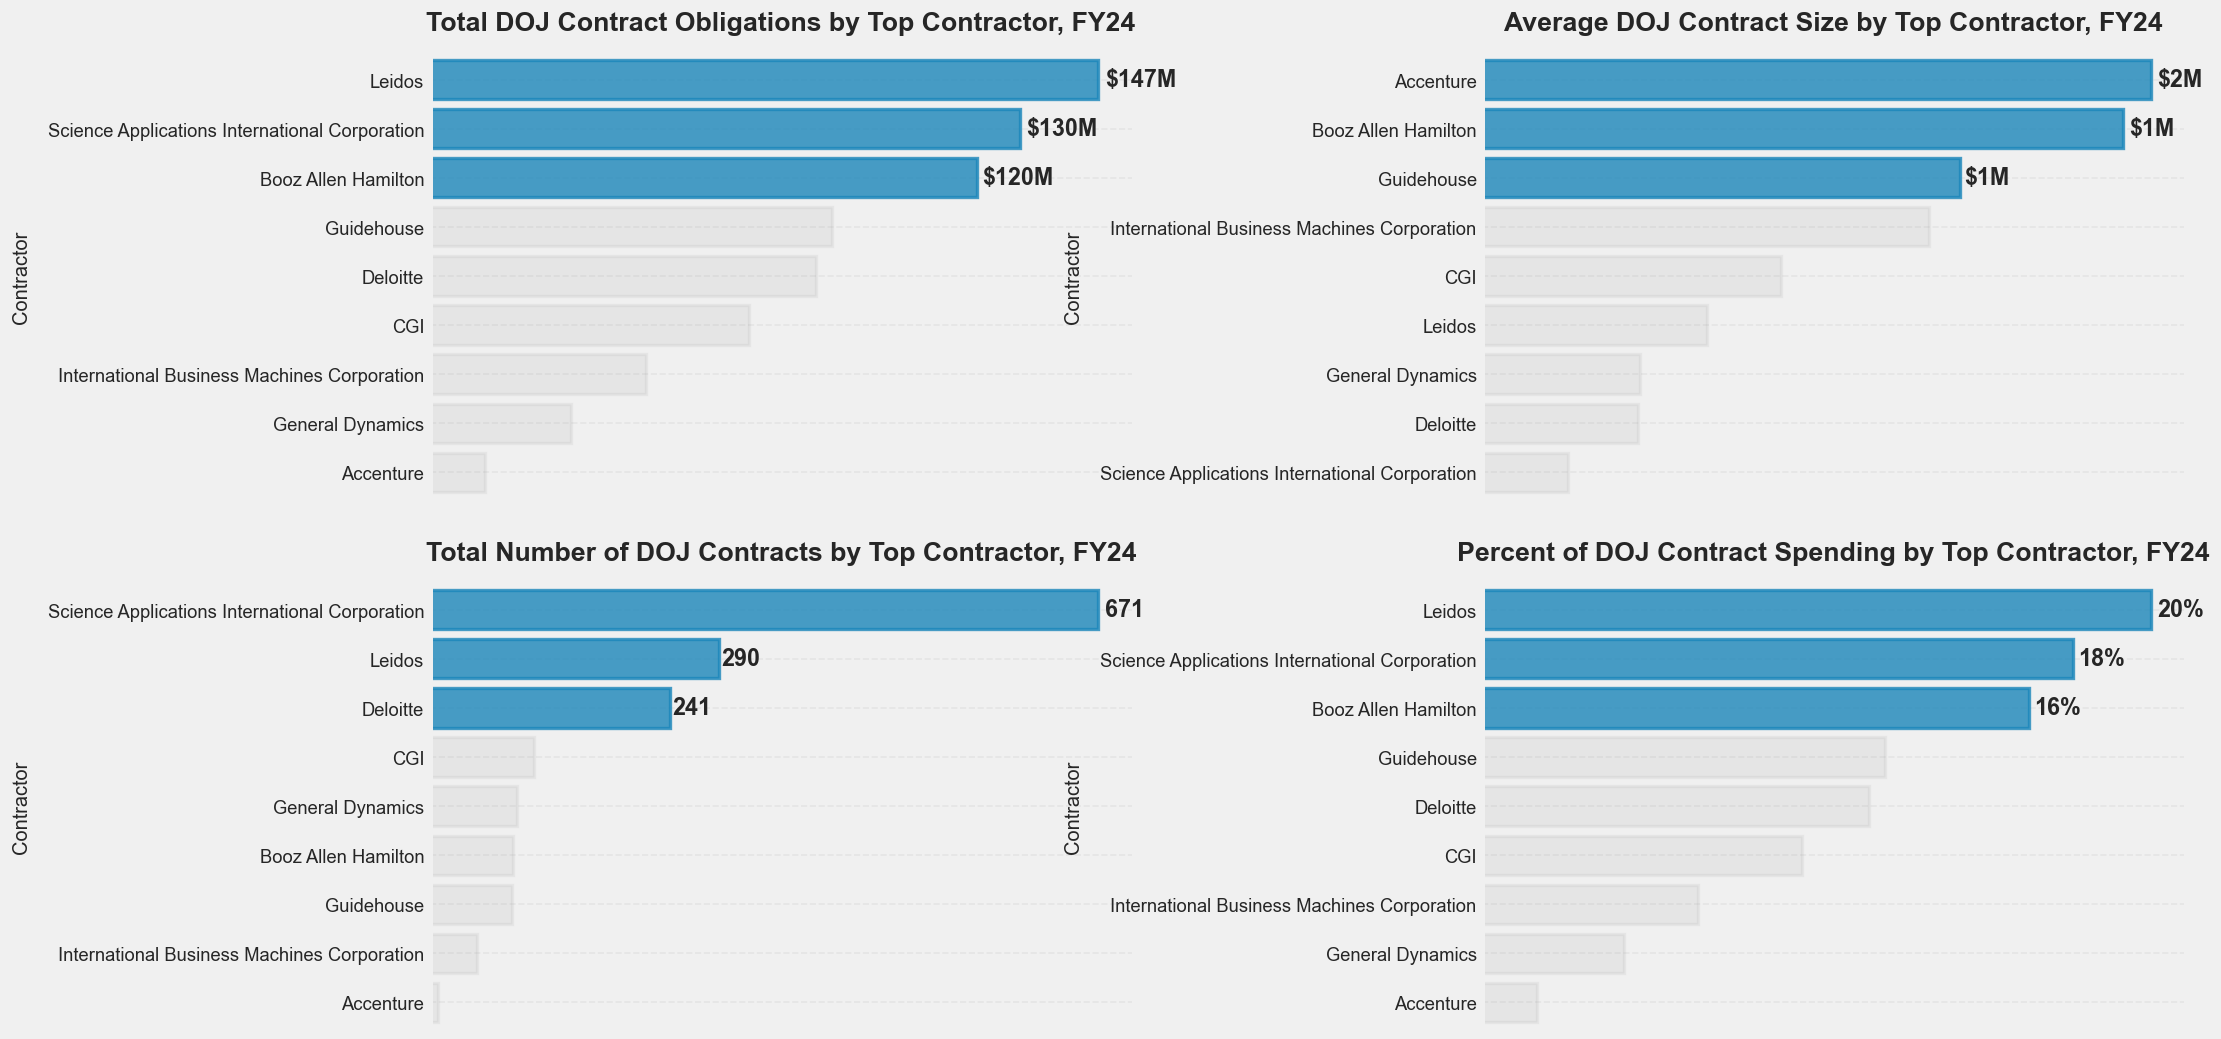

In [21]:
# Plot total contract obligations by Top Contractor along with average contract size, count of contracts, and percentage of spending
with plt.style.context('fivethirtyeight'):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    # Create a 2x2 subplot layout with an increased figure size
    fig, axs = plt.subplots(2, 2, figsize=(16.8, 10),
                            gridspec_kw={'hspace': 0.2, 'wspace': 0.5})
    
    # 1. Total contract obligations (Top-Left)
    create_contractor_summary_plot(
        ax=axs[0,0],
        data=obligation_stats_contractor_fy24['sum'].sort_values(ascending=False),
        plot_type='sum',
        title='Total DOJ Contract Obligations by Top Contractor, FY24',
        xlabel='Total Obligations ($ Millions)',
        ylabel='Contractor',
        max_value=obligation_stats_contractor_fy24['sum'].quantile(0.75),
        colors=colors,
        unit=1e6,
        unit_name='M'
    )

    # 2. Average contract size (Top-Right)
    create_contractor_summary_plot(
        ax=axs[0,1],
        data=obligation_stats_contractor_fy24['mean'].sort_values(ascending=False),
        plot_type='mean',
        title='Average DOJ Contract Size by Top Contractor, FY24',
        xlabel='Average Contract Size ($ Millions)',
        ylabel='Contractor',
        max_value=obligation_stats_contractor_fy24['mean'].quantile(0.75),
        colors=colors,
        unit=1e6,
        unit_name='M'
    )

    # 3. Count of contracts (Bottom-Left)
    create_contractor_summary_plot(
        ax=axs[1,0],
        data=award_stats_contractor_fy24['count'].sort_values(ascending=False),
        plot_type='count',
        title='Total Number of DOJ Contracts by Top Contractor, FY24',
        xlabel='Number of Contracts',
        ylabel='Contractor',
        max_value=award_stats_contractor_fy24['count'].quantile(0.75),
        colors=colors
    )

    # 4. Percentage of spending (Bottom-Right)
    create_contractor_summary_plot(
        ax=axs[1,1],
        data=obligation_stats_contractor_fy24['percent_of_total'].sort_values(ascending=False),
        plot_type='percentage',
        title='Percent of DOJ Contract Spending by Top Contractor, FY24',
        xlabel='Percentage of Total DOJ Contract Spending',
        ylabel='Contractor',
        max_value=obligation_stats_contractor_fy24['percent_of_total'].quantile(0.75),
        colors=colors
    )

    # Adjust layout with more padding 
    plt.tight_layout()
    plt.show()


### Recommendations for Addressing Contract Obligation Skew
1. **Expand and Diversify Vendor Base**: Encourage the inclusion of smaller and mid-sized contractors to reduce dependency on the top 10.
2. **Review and Optimize Contract Award Strategies**: Reassess the awarding process to balance total obligations and contract counts, and explore unbundling high-value contracts (e.g., **Booz Allen Hamilton’s** average of \$4M) to stimulate competition.
3. **Standardize Engagement Models**: Establish consistent evaluation criteria to normalize disparities in contract sizes and distribute risk fairly across contractors.
4. **Streamline Contract Administration**: Consolidate fragmented contracts (such as **SAIC’s** high volume of smaller contracts) to reduce administrative burden and leverage economies of scale.
5. **Implement Monitoring and Control Mechanisms**: Regularly assess contractor concentration and spending distribution, enforce spending caps for each DOJ component, and develop contingency plans for contractor transition.

## Temporal Patterns
**SUMMARY**
- Contract awards show distinct quarterly patterns throughout the fiscal years
- Year-over-year growth rates between FY23 and FY24 highlight evolving contractor relationships
- Several contractors demonstrate consistent quarter-over-quarter growth in contract value

The following reveals distinct patterns in DOJ contract spending, which highlights strategic contractor positioning and agency spending behaviors.

### Q4 Peaks and Risks
Quarterly spending patterns show significant concentration in Q4, particularly for **Booz Allen Hamilton**, indicating potential "use it or lose it" budget execution at fiscal year-end. Several other contractors demonstrate quarter-to-quarter volatility rather than steady growth, suggesting project-based rather than retainer-based engagement models. **SAIC** maintains consistent high-value engagement across multiple quarters, indicating stable, long-term contractual relationships.

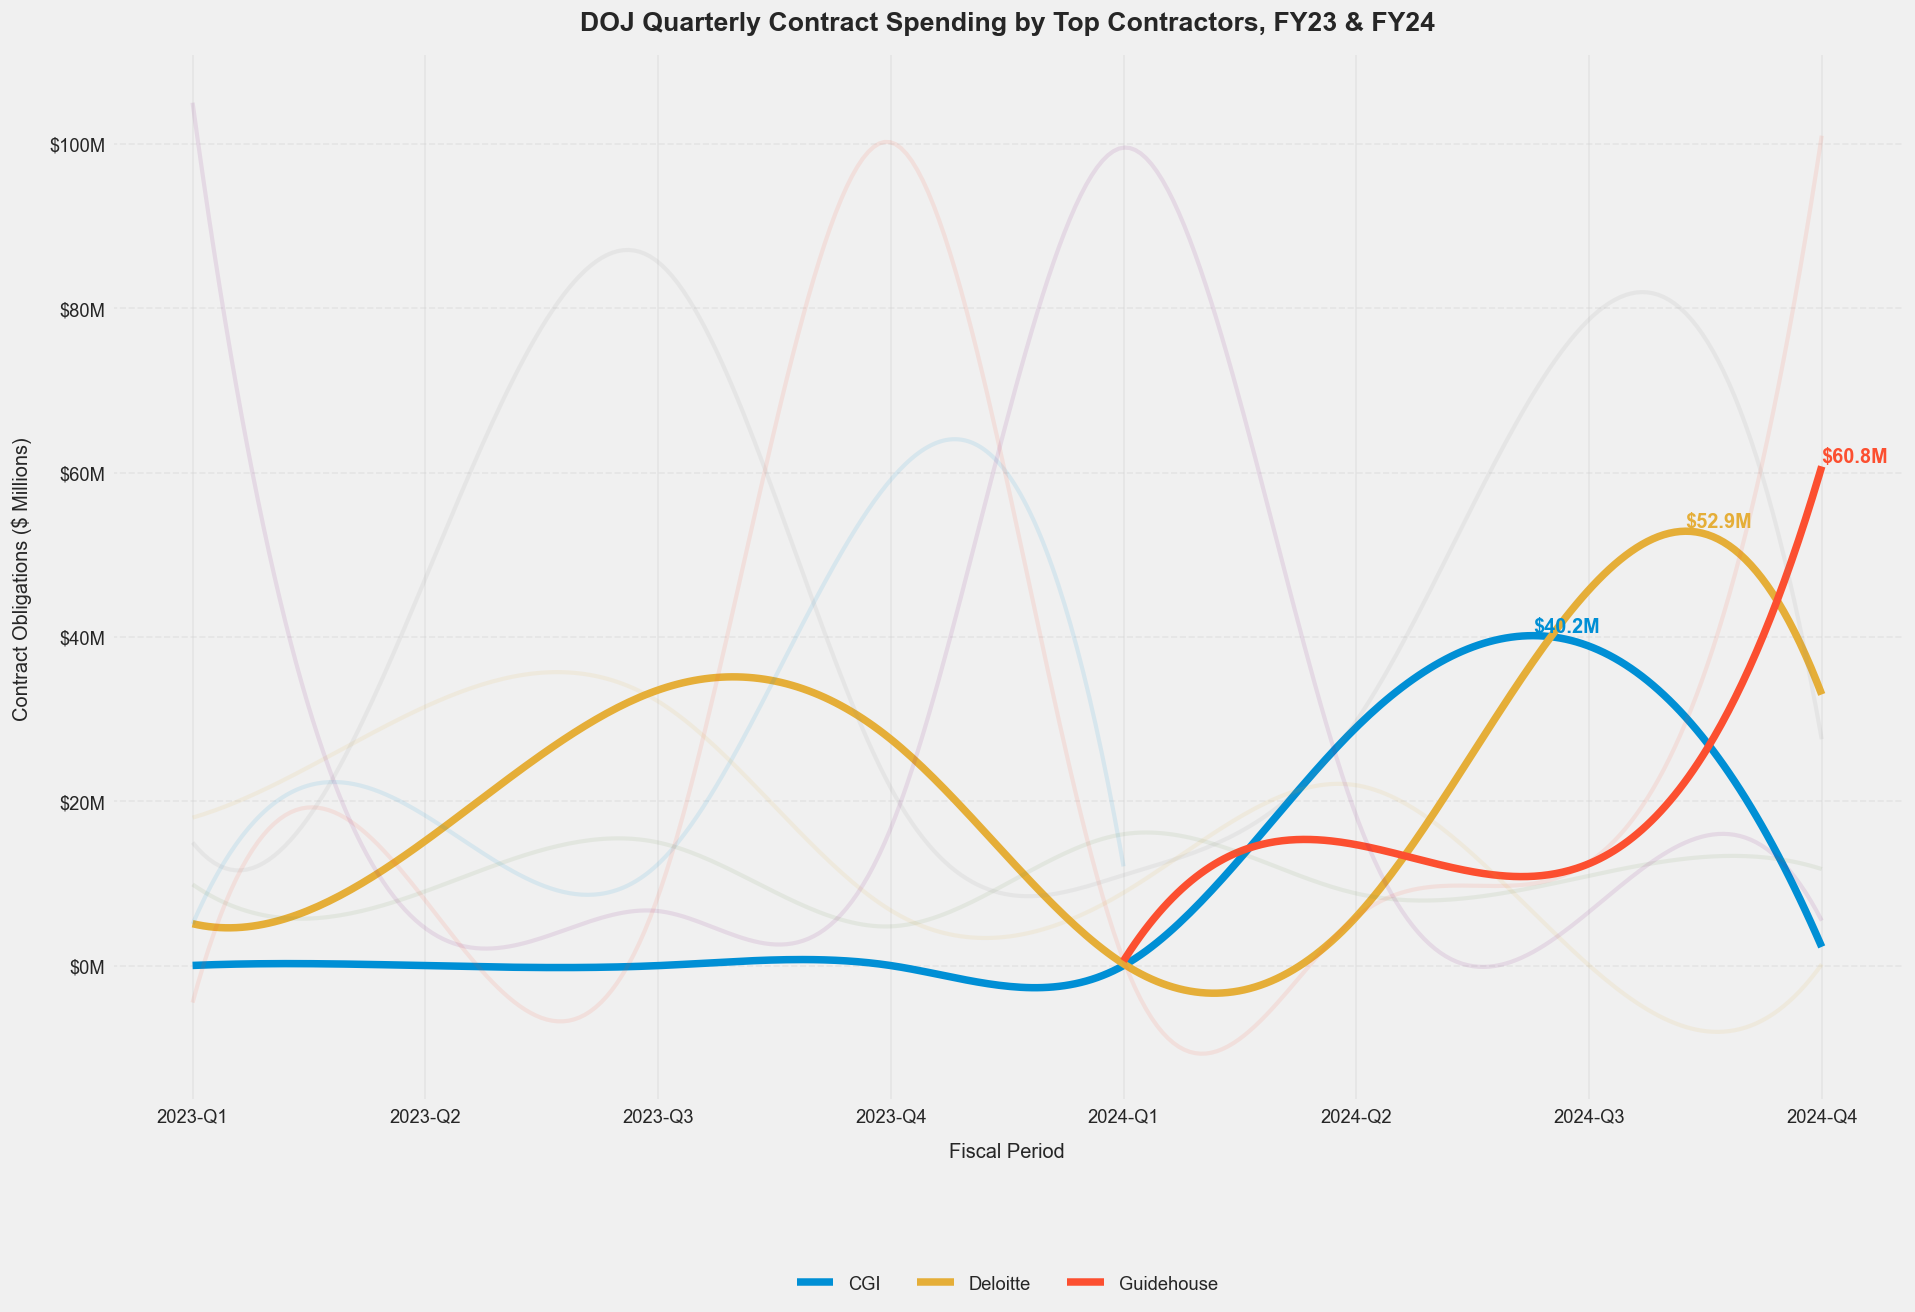

In [22]:
# Plot the total contract obligations by Top Contractor over time
with plt.style.context('fivethirtyeight'):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(16.18, 10))
    
    # Convert values to millions for better readability and perform smooth interpolation without markers
    for contractor in time_series_fy23_24.columns:
        x = np.arange(len(time_series_fy23_24.index))
        y = time_series_fy23_24[contractor].values / 1e6
        # Filter out NaN values
        mask = ~np.isnan(y)
        # If there are not enough data points for cubic spline interpolation, use the available points directly
        if mask.sum() < 4:
            ax.plot(x[mask], y[mask], linewidth=2.5, label=contractor, linestyle='-', alpha=0.5, zorder=2)
            continue
        x_valid = x[mask]
        y_valid = y[mask]
        x_new = np.linspace(x_valid.min(), x_valid.max(), 300)
        spl = make_interp_spline(x_valid, y_valid, k=3)
        y_smooth = spl(x_new)

        if contractor in top_three_contractors_quarterly_pct_change_fy23_24:
            # Use a distinct color for each top contractor based on their order in the top_three_contractors_quarterly_pct_change_fy23_24 list
            color = colors[top_three_contractors_quarterly_pct_change_fy23_24.index(contractor)]
            ax.plot(x_new, y_smooth, linewidth=4.5, label=contractor, color=color, linestyle='-', alpha=1, zorder=1)
            
            # Find the index of the maximum y_smooth value
            max_y_index = np.argmax(y_smooth)
            # Get the x and y values at the maximum point
            max_x = x_new[max_y_index]
            max_y = y_smooth[max_y_index]
            
            # Add data label at the maximum point
            ax.text(max_x, max_y, f'${max_y:.1f}M', color=color, fontsize=12, ha='left', va='bottom', fontweight='bold')
        else:
            ax.plot(x_new, y_smooth, linewidth=2.5, linestyle='-', alpha=0.1, zorder=2)
    
    # Set x-ticks and format y-axis values
    ax.set_xticks(np.arange(len(time_series_fy23_24.index)))
    ax.set_xticklabels(time_series_fy23_24.index, rotation=0)
    ax.yaxis.set_major_formatter(lambda x, pos: f'${x:.0f}M')
    
    # Apply consistent styling using the style_chart() function
    style_chart(ax,
                title='DOJ Quarterly Contract Spending by Top Contractors, FY23 & FY24',
                xlabel='Fiscal Period',
                ylabel='Contract Obligations ($ Millions)',
                data_labels=False,
                legend=True)
    
    # Create a legend only for the top three contractors
    handles, labels = ax.get_legend_handles_labels()
    top_three_handles = []
    top_three_labels = []
    for i, label in enumerate(labels):
        if label in top_three_contractors_quarterly_pct_change_fy23_24:
            top_three_handles.append(handles[i])
            top_three_labels.append(label)
    ax.legend(top_three_handles, top_three_labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)
    
    # plt.tight_layout()
    plt.show()


### Recommendations for Addressing Q4 Peaks and Risks
1. **Implement Quarterly Spending Targets**: Combat the "use it or lose it" mentality by establishing mandatory quarterly spending distribution targets, particularly addressing the excessive Q4 concentration seen with contractors like **Booz Allen Hamilton**.
2. **Develop Multi-Year Procurement Planning**: Create rolling three-year procurement forecasts to smooth out quarter-to-quarter volatility and reduce rushed end-of-fiscal-year contracting decisions.
3. **Establish Retainer-Based Contract Models**: Transition from project-based to retainer-based engagement models where appropriate to create more predictable spending patterns and reduce administrative burden.
4. **Adopt Budget Carryover Provisions**: Work with appropriations committees to implement limited budget carryover authority, reducing the pressure to spend remaining funds before fiscal year-end.
5. **Replicate Successful Engagement Models**: Study and replicate the stable contractor relationship model demonstrated with **SAIC** across other DOJ Components to promote consistency and long-term value.
6. **Implement Performance Penalties for Rush Orders**: Introduce contract clauses that discourage last-minute spending by applying stricter performance requirements and reduced fees for contracts executed in the final weeks of the fiscal year.

### Outsized Year-over-Year Growth
Year-over-year spending growth varies dramatically between contractors, with **Booz Allen Hamilton** showing considerable expansion between FY23 and FY24 at 92.1%. **General Dynamics** experienced a notable decline (-19.3%) in DOJ contract obligations year-over-year. The average growth across all top 10 contractors was 30.4%.

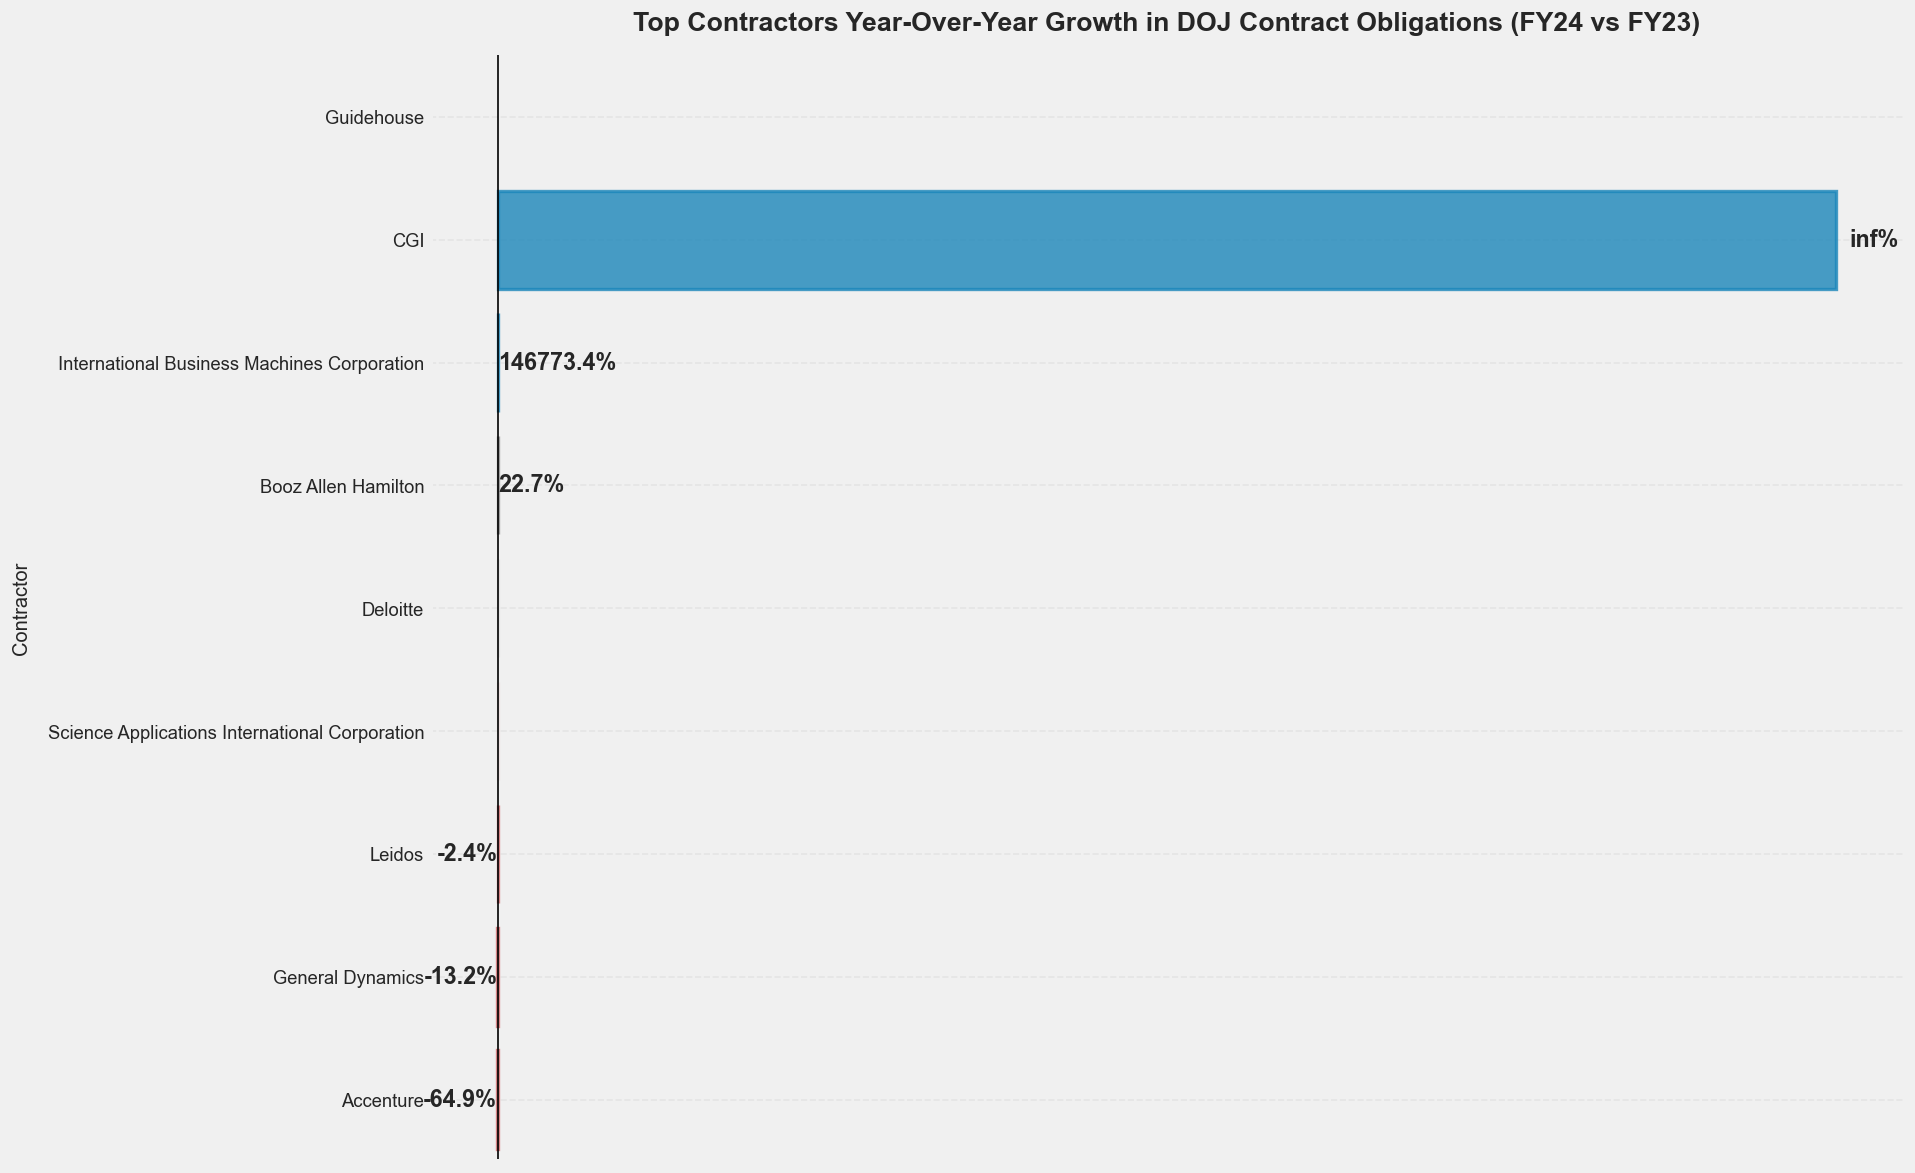

In [23]:
# Plot the year-over-year growth in contract obligations for the top contractors
with plt.style.context('fivethirtyeight'):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    fig, ax = plt.subplots(figsize=(16.18, 10))

    create_contractor_summary_plot(
        ax=ax,
        data=obligation_compare_contractor_fy23_24['Growth'].sort_values(ascending=False),
        plot_type='percentage',
        title='Top Contractors Year-Over-Year Growth in DOJ Contract Obligations (FY24 vs FY23)',
        xlabel='Growth (%)',
        ylabel='Contractor',
        max_value=obligation_compare_contractor_fy23_24['Growth'].quantile(0.75),
        colors=colors,
        decimals=1
    )

    # Add a vertical line at x=0
    ax.axvline(x=0, color='black', linestyle='-', linewidth=1)

    # Add a vertical red line that shows the average growth across all all_recipients
    ax.axvline(x=growth_stats_agency_fy23_24['mean'].iloc[0], color='red', linestyle='--', linewidth=2, label=f"Mean Growth: {growth_stats_agency_fy23_24['mean'].iloc[0]*100:.1f}%")
    ax.text(growth_stats_agency_fy23_24['mean'].iloc[0] + 0.02, ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.1, f"Average Growth: {growth_stats_agency_fy23_24['mean'].iloc[0]*100:.1f}%", color='red')
    
    plt.show()


### Recommendations for Addressing Outsized Year-over-Year Growth
1.  **Conduct Growth Trend Analysis**: Investigate the drivers behind the substantial growth of contractors like **Booz Allen Hamilton** and **Guidehouse** to determine whether it reflects increased value delivery or potential over-billing.
2.  **Negotiate Volume-Based Discounts**: Leverage the increased contract volume with high-growth contractors to negotiate volume-based discounts and improved service level agreements.
3.  **Promote Competitive Bidding**: Ensure that DOJ Components regularly solicit competitive bids for services provided by high-growth contractors to prevent vendor lock-in and promote cost efficiency.
4.  **Implement Performance-Based Incentives**: Restructure contracts to tie contractor compensation to measurable performance outcomes, incentivizing value delivery rather than simply rewarding increased spending.
5.  **Diversify Contractor Portfolio**: Actively seek opportunities to engage new contractors and reduce reliance on a small number of high-growth vendors, mitigating risks associated with over-dependence.

## Portfolio Composition
**SUMMARY**
- DOJ Component analysis reveals specialized relationships between certain contractors and specific DOJ Components.
- This specialization allows certain contractors to be well-positioned, securing a consistent stream of awards and potentially limiting competition.

Top contractors have strategically positioned themselves within DOJ to secure a consistent stream of awards and potentially limit competition. This is achieved through specialization within specific DOJ Components and a focus on particular contract types. The concentration of awards among a few key players raises concerns about potential vendor lock-in and reduced opportunities for new entrants.

### Component Specialization
The distribution of contractor activity across DOJ Components reveals clear specialization patterns. **CGI Federal** has a dominant presence within **OBD**, **Booz Allen Hamilton** at **FBI**, and **General Dynamics** is heavily involved with **OJP**.

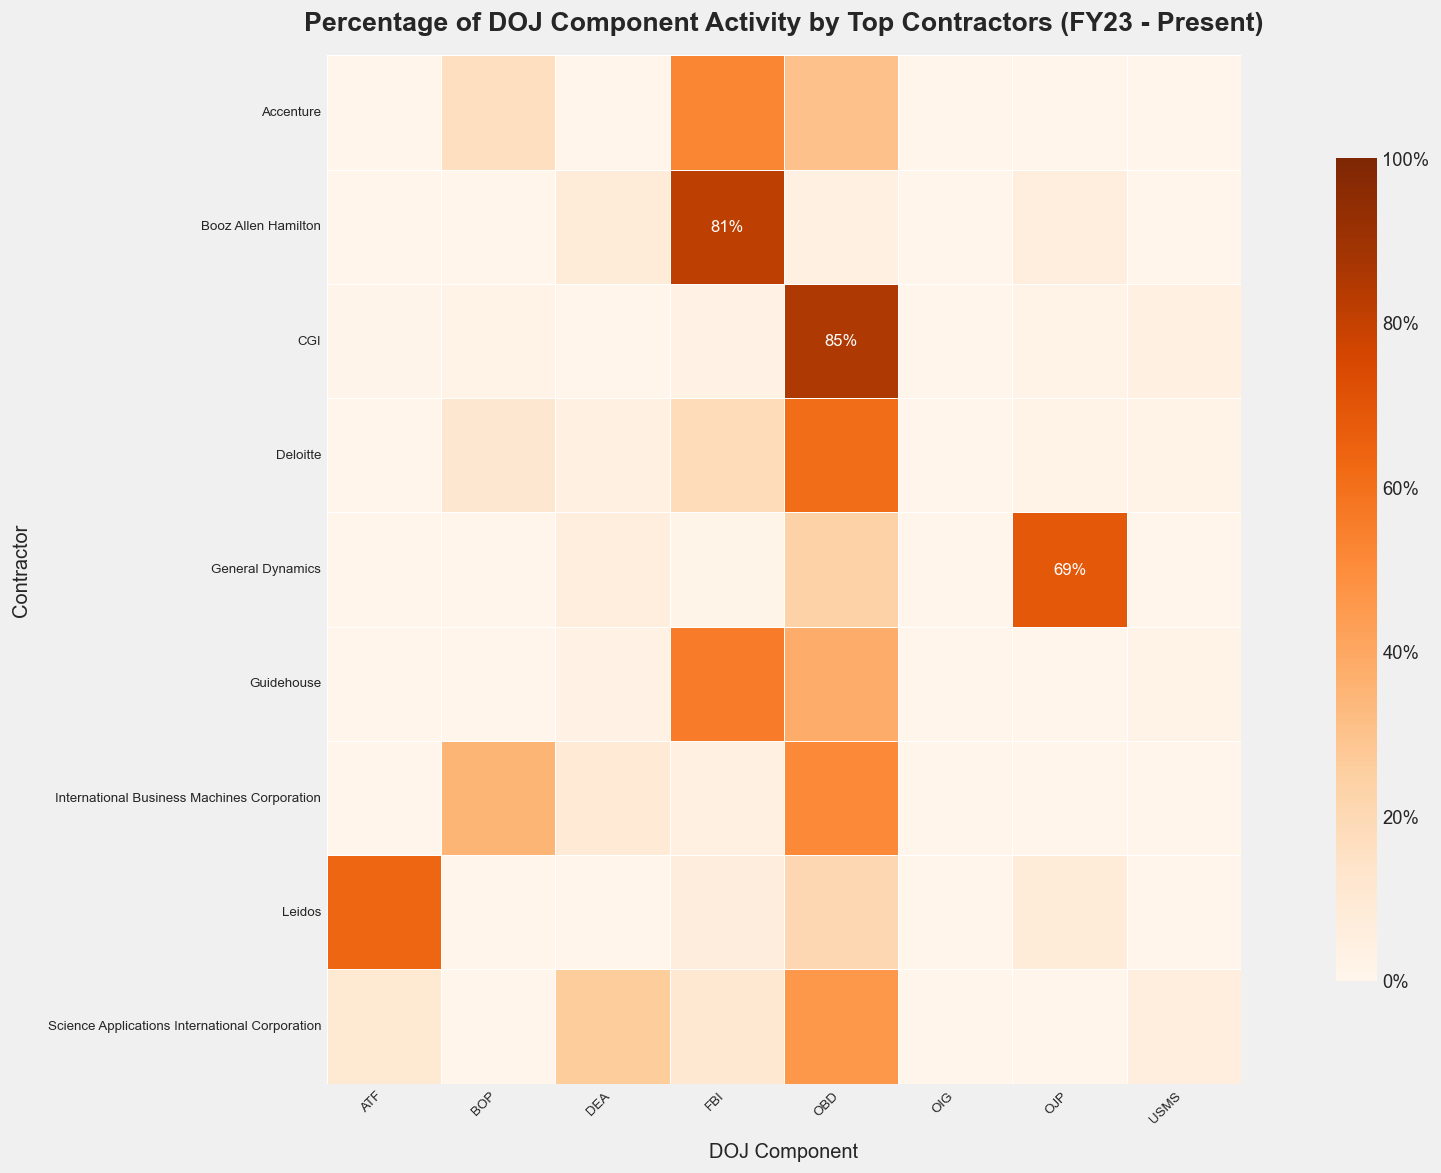

In [24]:
with plt.style.context('fivethirtyeight'):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    fig, ax = plt.subplots(figsize=(16.18, 10))
    sns.heatmap(obligation_component_contractor_all, cmap="Oranges", annot=True, fmt=".4f", linewidths=0.5, ax=ax, square=True, annot_kws={'size':10}, cbar_kws={'shrink':0.8},  cbar=True, vmin=0, vmax=1.0)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right', fontsize=8)
    for text in ax.texts: # Iterate through each text element in the heatmap
        try:
            value = float(text.get_text()) # Try to convert the text to a float value
            if value > obligation_component_contractor_all.max().quantile(0.7):
                text.set_text(f'{value * 100:.0f}%') # If it is, add a "%" sign to the text
            else:
                text.set_text('') # Otherwise, set the text to an empty string
        except ValueError:
            print('error')
            pass  # Handle non-numeric labels

        # Set the colorbar formatter to percentage
    cbar = ax.collections[0].colorbar
    cbar.ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
  
    style_chart(ax,
                title='Percentage of DOJ Component Activity by Top Contractors (FY23 - Present)',
                ylabel='Contractor',
                xlabel='DOJ Component',
                legend=False)
    
    plt.tight_layout()
    plt.show()

### Recommendations for Addressing Component Specialization
1.  **Promote Cross-Component Bidding**: Encourage contractors to bid on projects across multiple DOJ Components to reduce specialization and foster competition.
2.  **Rotate Contractors Across Components**: Implement a rotation program where contractors are periodically reassigned to different DOJ Components to prevent vendor lock-in and promote knowledge transfer.
3.  **Standardize Requirements Across Components**: Develop standardized requirements and procurement processes across DOJ Components to reduce the advantages of specialized contractors and level the playing field for new entrants.
4.  **Establish Knowledge Transfer Protocols**: Require incumbent contractors to document and transfer institutional knowledge to DOJ personnel and incoming contractors to mitigate the risks associated with specialization.
5. **Incentivize New Entrants**: Offer incentives, such as set-aside contracts or technical assistance, to encourage new contractors to enter specialized markets within DOJ Components.

### Award Type Dominance
The distribution of contractor activity by award type further illustrates strategic positioning. It reveals the dominance of certain contract types among the top contractors. This suggests a preference for specific procurement methods, potentially limiting the use of other contract vehicles that could foster broader competition or innovation. **IBM** and **Accenture** secure virtually all of their contracts through delivery orders (100\% and 97\%, respectively).

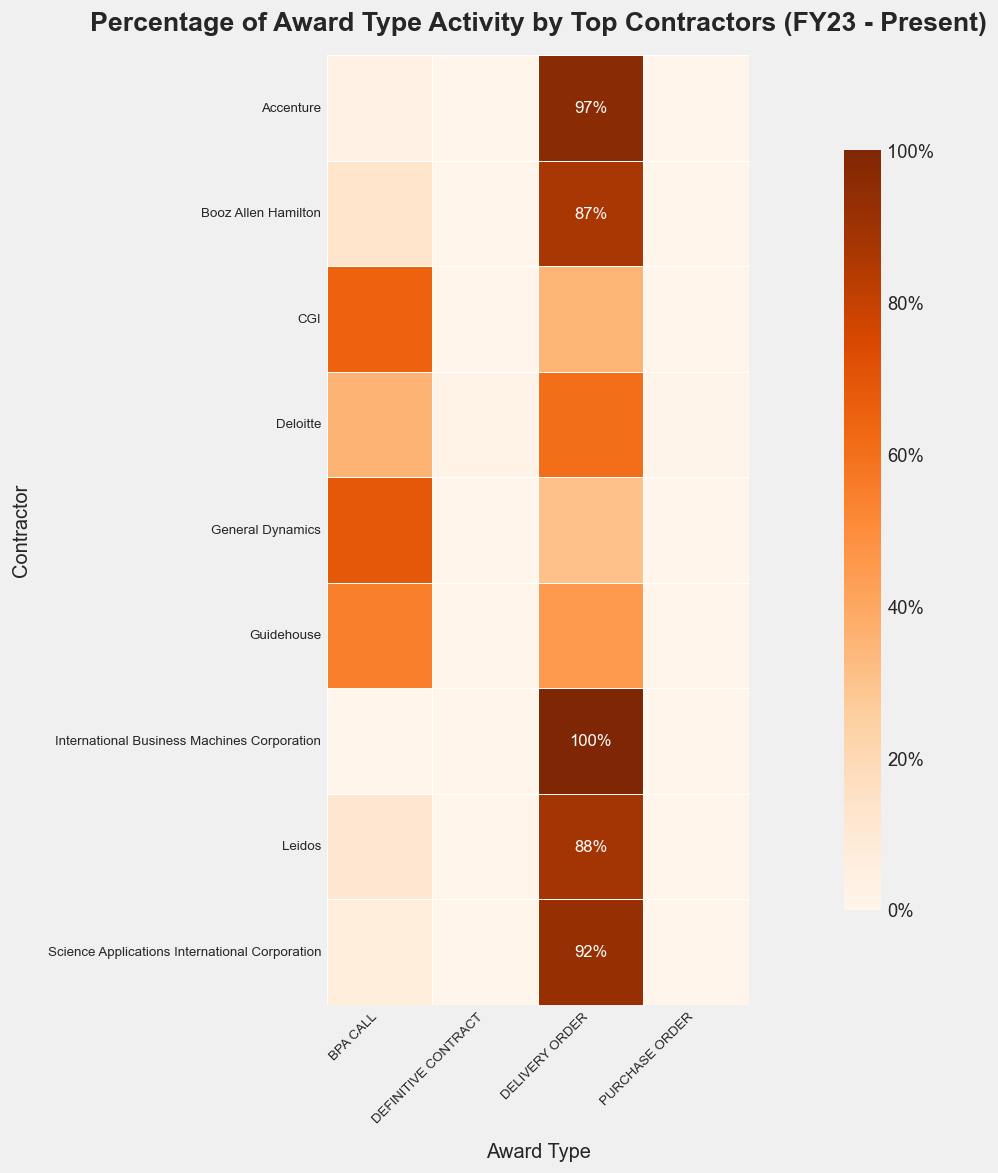

In [25]:
# Create a heatmap for award type activity
with plt.style.context('fivethirtyeight'):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    fig, ax = plt.subplots(figsize=(16.18, 10))
    sns.heatmap(obligation_award_type_contractor_all, cmap="Oranges", annot=True, fmt=".4f", linewidths=0.5, ax=ax, square=True, annot_kws={'size':10}, cbar_kws={'shrink':0.8},  cbar=True, vmin=0, vmax=1.0)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right', fontsize=8)
    for text in ax.texts: # Iterate through each text element in the heatmap
        try:
            value = float(text.get_text()) # Try to convert the text to a float value
            if value > obligation_award_type_contractor_all.max().quantile(0.75):
                text.set_text(f'{value * 100:.0f}%') # If it is, add a "%" sign to the text
            else:
                text.set_text('') # Otherwise, set the text to an empty string
        except ValueError:
            print('error')
            pass  # Handle non-numeric labels

        # Set the colorbar formatter to percentage
    cbar = ax.collections[0].colorbar
    cbar.ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
  
    style_chart(ax,
                title='Percentage of Award Type Activity by Top Contractors (FY23 - Present)',
                ylabel='Contractor',
                xlabel='Award Type',
                legend=False)
    
    plt.tight_layout()
    plt.show()

### Recommendations for Addressing Award Type Dominance
1. **Diversify Award Types**: Encourage DOJ Components to utilize a broader range of contract vehicles to avoid over-reliance on specific award types favored by incumbent contractors, such as definitive contracts with **Deloitte**.
2. **Incentivize Innovative Solutions**: Implement pilot programs that incentivize contractors to propose innovative solutions through less conventional award types (e.g., prize challenges, Other Transaction Authorities).
3. **Establish Performance Metrics for Award Types**: Develop performance metrics for each award type to assess their effectiveness and identify opportunities for optimization.
4. **Promote Knowledge Sharing**: Facilitate knowledge sharing across DOJ Components regarding the benefits and drawbacks of different award types to encourage informed decision-making.
5. **Regularly Review Award Type Usage**: Conduct regular reviews of award type usage to identify trends and ensure that DOJ Components are utilizing the most appropriate contract vehicles for their needs.

In [26]:
# # Create treemap
# fig = px.treemap(
#     treemap_df,
#     path=['Contractor', 'Category'],
#     values='Value',
#     title='DOJ Contract Spending by Top 10 U.S. Federal Government Contractor and NAICS Category'
# )
# fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))
# fig.show()

## Performance Metrics
**SUMMARY**
- Contract duration statistics reveal differences in engagement length across contractors
- Modification patterns indicate which contractors are more successful at expanding initial contract scope

Contract duration statistics highlight variations in engagement length across different contractors, while modification patterns reveal which contractors are more adept at expanding the scope of their initial agreements.

### Contract Durations
Average contract durations highlight contractors with potentially inefficient long-term engagements. **Leidos** holds the longest average contract durations with DOJ at 1,227 days, suggesting entrenched relationships or projects lacking clear end dates. **Deloitte** and **Guidehouse** also exhibit long average contract durations, each exceeding 815-day average.

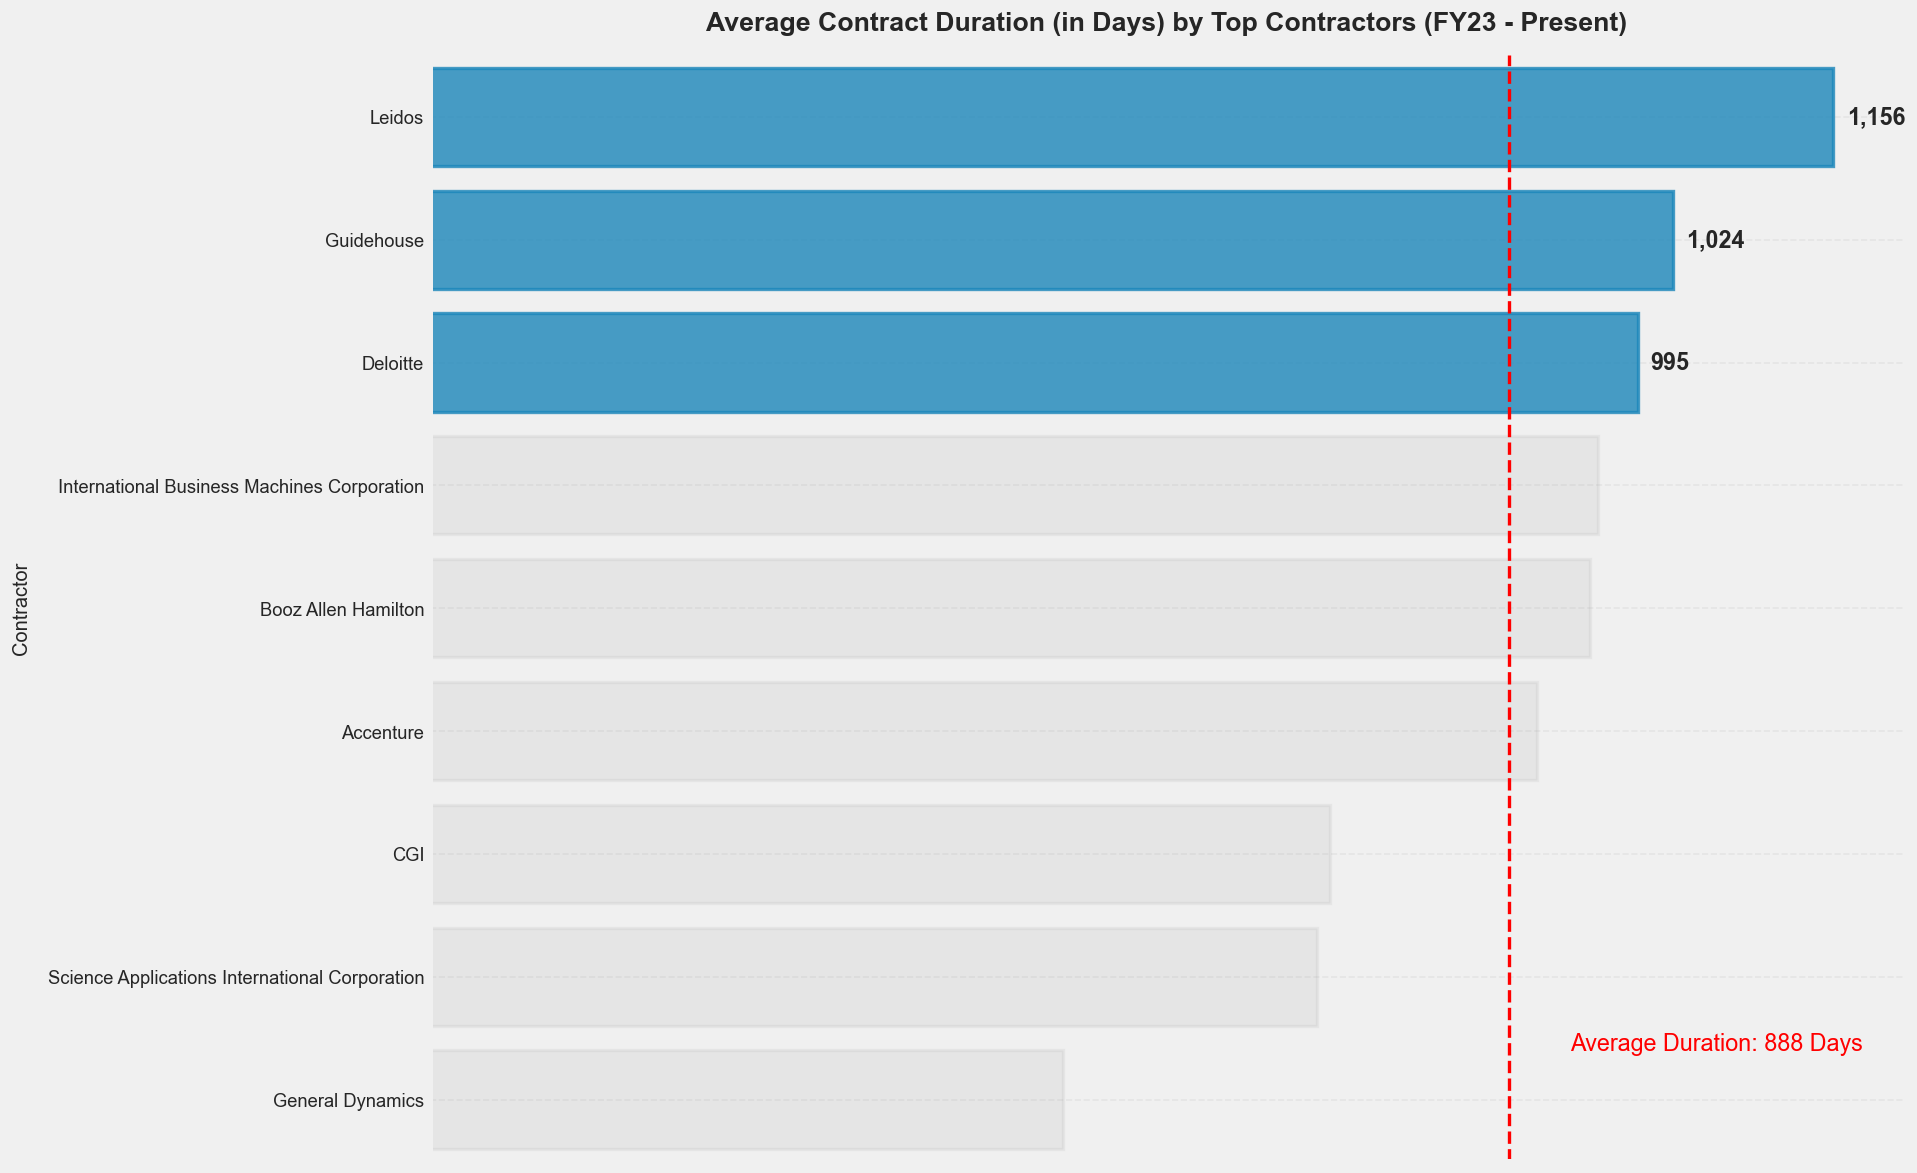

In [27]:
# visualize the average duration of contracts by Top Contractor
with plt.style.context('fivethirtyeight'):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(16.18, 10))

    create_contractor_summary_plot(
        ax=ax,
        data=duration_stats_contractor_all['mean'].sort_values(ascending=False),
        plot_type='count',
        title='Average Contract Duration (in Days) by Top Contractors (FY23 - Present)',
        xlabel='Average Duration',
        ylabel='Contractor',
        max_value=duration_stats_contractor_all['mean'].quantile(0.75),
        colors=colors,
        unit=1,
        unit_name=''
    )

    # Add a vertical red line that shows the average duration across all contractors
    ax.axvline(x=duration_stats_contractor_all['mean'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean Duration: {duration_stats_contractor_all['mean'].mean():.0f} Days")
    ax.text(duration_stats_contractor_all['mean'].mean() + 50, ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.1, f"Average Duration: {duration_stats_contractor_all['mean'].mean():.0f} Days", color='red')

    plt.show()


### Recommendations for Addressing Contract Durations
1.  **Implement Regular Performance Reviews**: Conduct frequent performance reviews for long-duration contracts, particularly those held by **Leidos**, to ensure continued value delivery and alignment with DOJ objectives.
2.  **Incorporate Milestone-Based Payments**: Restructure contracts to include milestone-based payments, incentivizing contractors to achieve specific outcomes within defined timeframes and allowing for earlier termination if milestones are not met.
3.  **Establish Clear End Dates**: Define clear end dates for all contracts, avoiding evergreen clauses or automatic renewals that can lead to inefficient long-term engagements.
4.  **Promote Competitive Re-Bidding**: Regularly re-bid long-duration contracts to ensure that DOJ is receiving the best possible value and to encourage new entrants to compete for the work.
5.  **Develop Transition Plans**: Create detailed transition plans for long-duration contracts, outlining the steps necessary to transfer knowledge and responsibilities to new contractors or DOJ personnel at the end of the contract term.

In [28]:
# # Visualize competition types
# with plt.style.context('fivethirtyeight'):
#     colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

#     # Calculate percentages for the stacked bar chart
#     obligation_extent_competed_contractor_all_pct = obligation_extent_competed_contractor_all.copy()
#     for col in obligation_extent_competed_contractor_all_pct.columns:
#         obligation_extent_competed_contractor_all_pct[col] = obligation_extent_competed_contractor_all_pct[col] * 100

#     # Determine the contractor with the maximum 'FULL AND OPEN COMPETITION' value
#     if 'FULL AND OPEN COMPETITION' in obligation_extent_competed_contractor_all_pct.columns:
#         max_value = obligation_extent_competed_contractor_all_pct['FULL AND OPEN COMPETITION'].idxmax()
#     else:
#         max_value = None

#     # Create figure and axis
#     fig, ax = plt.subplots(figsize=(16.18, 10))

#     # Plot stacked bar chart
#     obligation_extent_competed_contractor_all_pct.plot(kind='barh', stacked=True, ax=ax, colormap='RdYlGn')

#     # Customize appearance
#     style_chart(ax,
#                 title='Competition Type Distribution by Top Contractor (FY23 - Present)',
#                 xlabel='Percentage of Contract Value',
#                 ylabel='Contractor',
#                 legend=True,
#                 legend_loc='lower center')

#     # Annotate bars with percentage values
#     for i, contractor in enumerate(obligation_extent_competed_contractor_all_pct.index):
#         total_width = 0
#         for j, col in enumerate(obligation_extent_competed_contractor_all_pct.columns):
#             width = obligation_extent_competed_contractor_all_pct.loc[contractor, col]
#             if width > 5:  # Adjust threshold as needed
#                 x_pos = total_width + (width / 2)
#                 ax.text(x_pos, i, f'{width:.1f}%', ha='center', va='center', color='black', fontsize=8)
#             total_width += width

#     plt.tight_layout()
#     plt.show()

# # # Network analysis of contractors and DOJ components
# # G = nx.Graph()

# # # Add contractor nodes
# # for contractor in df_top_contractors_transactions['top_contractor'].unique():
# #     G.add_node(contractor, type='contractor')

# # # Add DOJ component nodes
# # for component in df_top_contractors_transactions['funding_sub_agency_name'].unique():
# #     G.add_node(component, type='component')

# # # Add edges based on contract relationships
# # for _, row in df_top_contractors_transactions.iterrows():
# #     contractor = row['top_contractor']
# #     component = row['funding_sub_agency_name']
# #     value = row['federal_action_obligation']
    
# #     # Check if edge already exists
# #     if G.has_edge(contractor, component):
# #         # Add to existing edge weight
# #         G[contractor][component]['weight'] += value
# #     else:
# #         # Create new edge
# #         G.add_edge(contractor, component, weight=value)

# # # Create node position layout
# # pos = nx.spring_layout(G, k=0.3, iterations=50)

# # # Create lists of contractor and component nodes
# # contractor_nodes = [node for node in G.nodes() if node in df_top_contractors_transactions['top_contractor'].unique()]
# # component_nodes = [node for node in G.nodes() if node in df_top_contractors_transactions['awarding_sub_agency_name'].unique()]

# # # Create edge weights
# # edge_weights = [G[u][v]['weight'] / 10000000 for u, v in G.edges()]

# # # Plot the network
# # with plt.style.context('fivethirtyeight'):
# #     colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# #     plt.figure(figsize=(16.18, 10))
# #     # Draw contractor nodes
# #     nx.draw_networkx_nodes(G, pos, nodelist=contractor_nodes, node_color='lightblue', 
# #                         node_size=700, alpha=0.8, label='Contractors')
# #     # Draw component nodes
# #     nx.draw_networkx_nodes(G, pos, nodelist=component_nodes, node_color='lightgreen', 
# #                         node_size=700, alpha=0.8, label='DOJ Components')
# #     # Draw edges
# #     nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.5, edge_color='gray')
# #     # Add labels
# #     nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

# #     plt.title("Contractor-DOJ Component Relationship Network")
# #     plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
# #               fancybox=True, shadow=True, ncol=2)
# #     plt.axis('off')
# #     plt.tight_layout()
# #     plt.show()

### Contract Modifications

Contract modifications indicate how well the initial contract scope is managed, and high modification rates can signal issues with requirements definition, project management, or contractor performance. **Guidehouse** leads with the most frequent expansion of their DOJ contracts, averaging 4.89 modifications per contract.

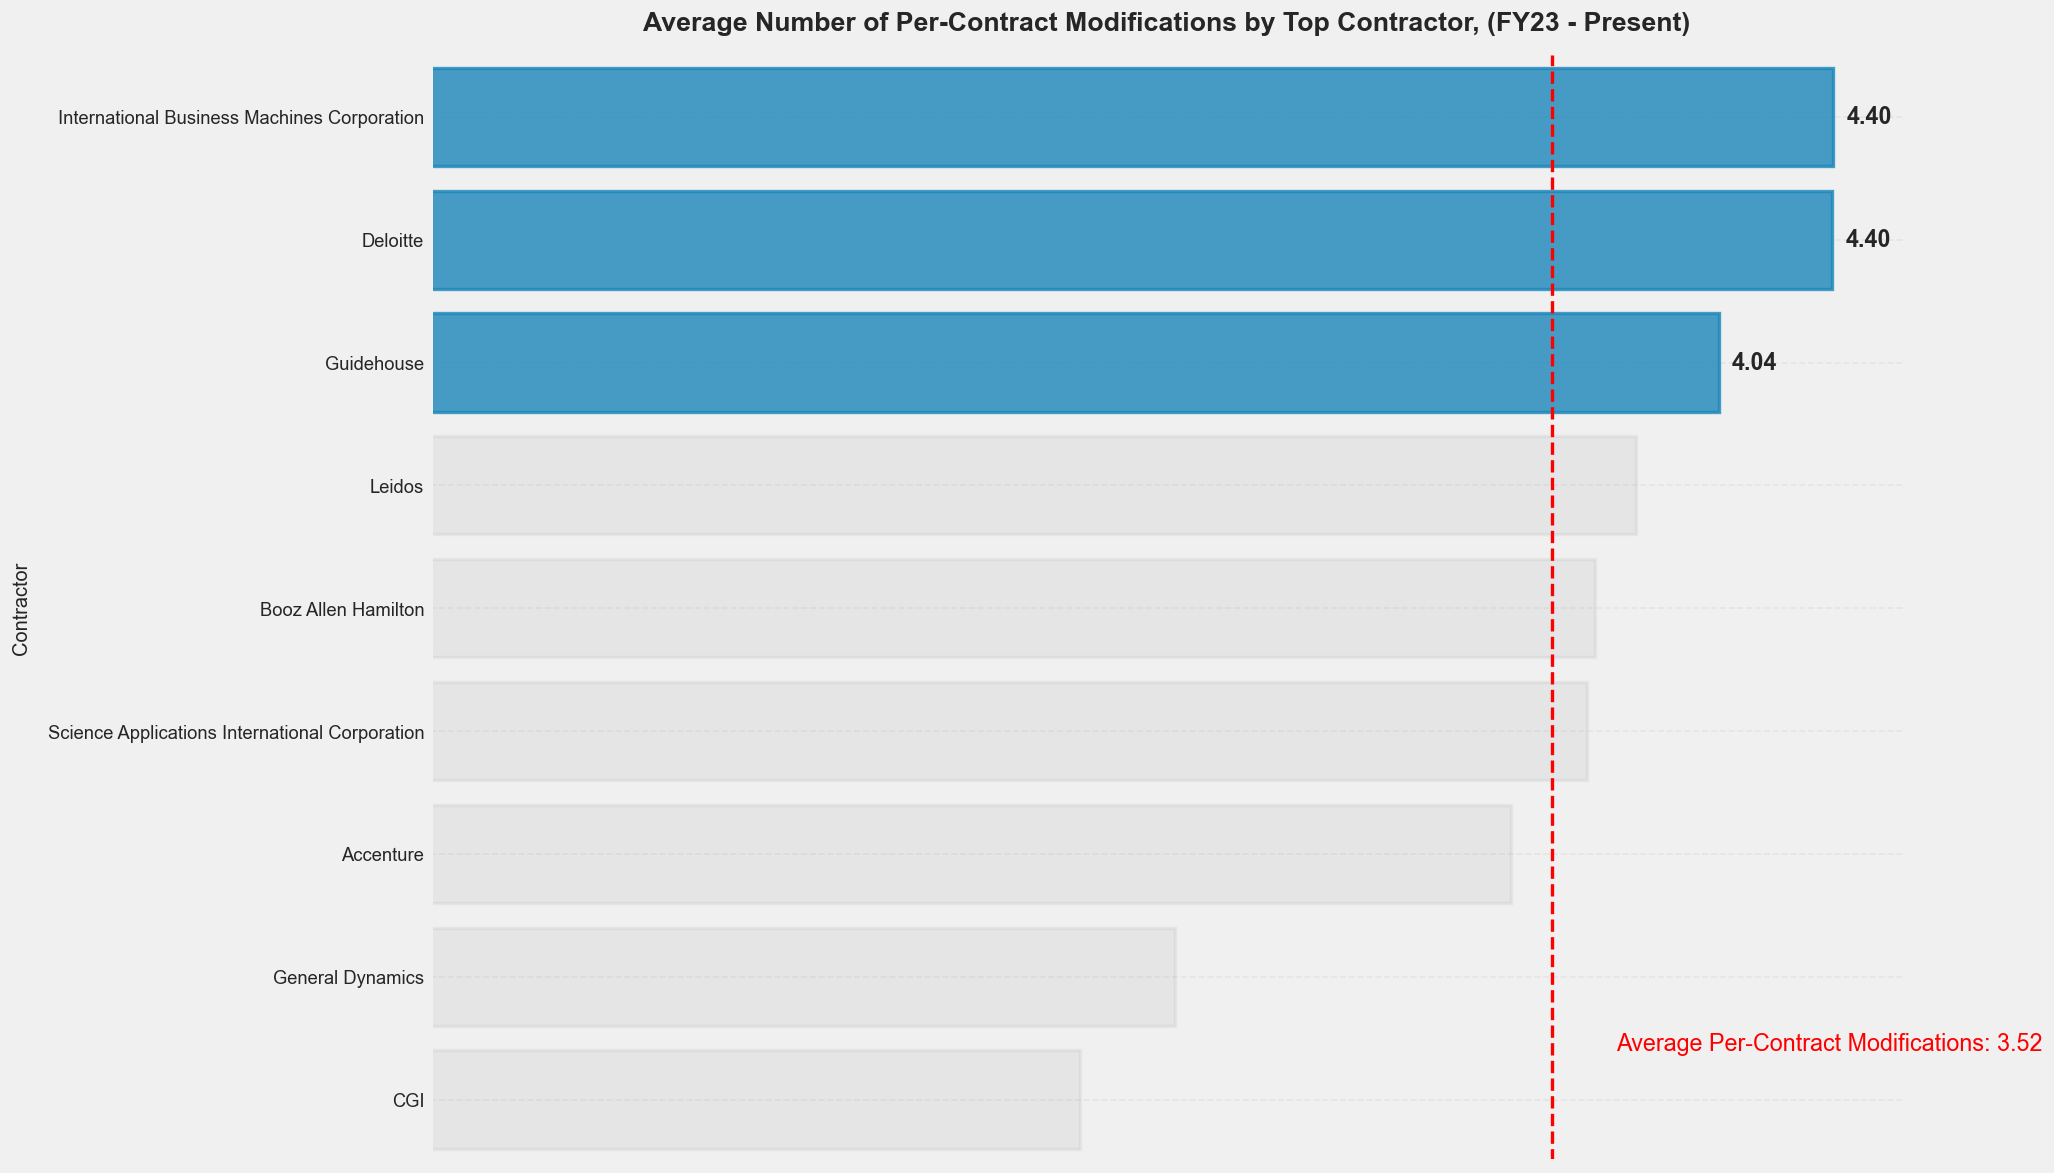

In [29]:
# create visualization on the contractors that are adept at expanding the scope of their initial agreements via modification patterns
# Visualize contract modifications
with plt.style.context('fivethirtyeight'):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    fig, ax = plt.subplots(figsize=(16.18, 10))

    create_contractor_summary_plot(
        ax=ax,
        data=modfication_stats_contractor_all['mean'].sort_values(ascending=False),
        plot_type='count',
        title='Average Number of Per-Contract Modifications by Top Contractor, (FY23 - Present)',
        xlabel='Average Number of Per-ContractModifications',
        ylabel='Contractor',
        max_value=modfication_stats_contractor_all['mean'].quantile(0.75),
        colors=colors,
        unit=1,
        unit_name='',
        decimals=2
    )

    # Add a vertical red line that shows the average number of contracts for all contractors
    ax.axvline(x=modfication_stats_contractor_all['mean'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean Modifications: {modfication_stats_contractor_all['mean'].mean():.2f}")
    ax.text(modfication_stats_contractor_all['mean'].mean() + 0.2, ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.1, f"Average Per-Contract Modifications: {modfication_stats_contractor_all['mean'].mean():.2f}", color='red')
    
    plt.show()

### Recommendations for Addressing Contract Modifications
1. **Negotiate Fixed-Price Modifications**: Where possible, negotiate fixed-price modifications to control costs and incentivize contractors to manage scope effectively. This shifts the risk of cost overruns from DOJ Components to the contractor.
2. **Track and Analyze Modification Trends**: Monitor modification patterns to identify root causes and implement corrective actions. This includes tracking the number, cost, and type of modifications, as well as the contractors and DOJ Components involved.

<!-- ### Competitive Landscape
- Contract competition types vary significantly across contractors
- Some contractors secure a higher percentage of sole-source contracts -->

In [31]:
def convert_notebook_with_lowercase_ids(notebook_path):
    """
    Convert a Jupyter notebook to HTML with all IDs in lowercase and then convert the HTML to PDF.
    
    Args:
        notebook_path (str): Path to the notebook file
    """
    # Get the base filename without extension
    base_name = os.path.splitext(notebook_path)[0]
    html_file = f"{base_name}.html"
    pdf_file = f"{base_name}.pdf"
    
    # Step 1: Convert notebook to HTML using nbconvert
    result = subprocess.run([
        'jupyter', 'nbconvert',
        '--to', 'html',
        '--TagRemoveOutputPreprocessor.remove_input_tags="{\'remove_input\'}"',
        '--TemplateExporter.exclude_input=True',  # Hide code cells
        notebook_path
    ], capture_output=True, text=True)

    if result.returncode != 0:
        print(f"Error converting notebook to HTML: {result.stderr}")
        return

    # Step 2: Read the generated HTML file
    try:
        with open(html_file, 'r', encoding='utf-8') as f:
            html_content = f.read()
    except Exception as e:
        print(f"Error reading HTML file: {e}")
        return
    
    # Step 3: Use regex to find all ID attributes and convert them to lowercase
    # Pattern to match id="SomeId" attributes
    id_pattern = re.compile(r'id="([^"]+)"')
    modified_html = id_pattern.sub(lambda m: f'id="{m.group(1).lower()}"', html_content)
    
    # Also convert href="#SomeId" (internal links) to lowercase
    href_pattern = re.compile(r'href="#([^"]+)"')
    modified_html = href_pattern.sub(lambda m: f'href="#{m.group(1).lower()}"', modified_html)
    
    # Step 4: Write the modified HTML back to the file
    try:
        with open(html_file, 'w', encoding='utf-8') as f:
            f.write(modified_html)
    except Exception as e:
        print(f"Error writing modified HTML file: {e}")
        return
    
    # # Step 5: Convert the HTML file to PDF using pdfkit
    # try:
    #     pdfkit.from_file(html_file, pdf_file)
    #     print(f"Successfully converted HTML to PDF: {pdf_file}")
    # except ImportError:
    #     print("pdfkit is not installed. Please install it using: pip install pdfkit")
    # except OSError as e:
    #     print(f"Error converting HTML to PDF using pdfkit. This is often due to missing wkhtmltopdf. Please ensure it is correctly installed and in your PATH. Original error: {e}")
    # except Exception as e:
    #     print(f"Error converting HTML to PDF using pdfkit: {e}")

# Export to HTML and then convert IDs to lowercase, then convert to PDF
convert_notebook_with_lowercase_ids('USA_Spending_Contractor_Analysis.ipynb')